# Analysis of County-Level US Presidential Election Winners

## Overview
I was tasked with creating a model to predict which party will win more votes in a county in a United States presidential election based on various demographic features of that county. This model can be used by political parties to identify emerging counties of interest in the lead-up to an election to help guide their decisions on where to allocate advertising, field organizing, and other resources.

I used county-level demographic and presidential election data from the US Census Bureau and MIT Election Data + Science Lab that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout. In this dataset, a county is assigned a "positive result" (1) if the Republican got the most votes in that county, and a "negative result" (0) if the Democrat got the most votes in that county.

When building my models, I prioritized maximizing recall (to avoid "false negatives" - counties that we predicted would vote Democratic but actually voted Republican) to minimize the chance that we would lose a county that we expected to win - a result that may cost us a national election. I also prioritized accuracy, because each incorrect prediction in either direction may cost us valuable campaign dollars or electoral votes.

After numerous attempts, I selected a final model that used a simplified version of my dataset and a K Nearest Neighbors classifier with a nine-neighbor hyperparameter because it had the highest recall score of any of the models I created, with comparable accuracy, precision, and f1 scores. This model had a recall of nearly 81%.

Based on the analysis below, I can make the following recommendations:
1. Keep a particularly careful eye on counties where a large proportion is not in the labor force. This was the key predictor of Republican victories in one model, and an important feature in multiple models.
2. The party should use a distance-based model, such as a K Nearest Neighbors model, to generate its predictions because this model generated highest recall score, meaning it was the least likely to incorrectly predict a Democratic victory (false negative, in the context of this model). These incorrect predictions have the greatest downside to the party because they may result in losing an election unexpectedly.
3. Based on which predictions were incorrect, I recommend that the Democratic Party work to shore up its base to avoid further surprising electoral losses in counties with lower White populations, and adopt positions that will help it to win back voters with a high school or lower education to stem the tide of surprising losses in these counties that it has faced in the last four elections.

## Business Problem
Despite winning three of the last four presidential elections, the Democratic Party in the United States faces a perilous political future. A [small number of states](https://www.cnn.com/2022/11/22/politics/2022-preview-2024-presidential-election/index.html) hold the key to swinging any given presidential contest. The near-inverse results of the 2016 and 2020 elections in terms of total electoral college votes despite [small swings in the popular vote margins of these states](https://www.washingtonpost.com/elections/election-results/president-2020/) demonstrates the importance of allocating campaign resources efficiently.

The 2020 election proved that the Democratic Party can return states it had lost in 2016 to its column (Michigan, Wisconsin, Pennsylvania) while simultaneously picking up new states for the first time since the 1990s (Arizona, Georgia). In order to protect these gains, and expand the electoral map to open new opportunities, the party must have an understanding of what factors make a state likely to tip to one party or the other in the coming years.

I chose to conduct my analysis at the county level because while presidential elections are decided at the state level, political parties build operations (such as "get out the vote" efforts and digital advertising campaigns) that target voters at the most granular geographic level possible and need information to guide these decisions. Additionally, these predictions are only meant to be one piece of the puzzle - they can be put in the broader political context of the state and nation as part of the process of developing a comprehensive campaign strategy. 

By building a predictive model to project the winner of presidential elections at the county level, the party can better understand what factors make a given area likely to vote one way or the other in coming elections. It can use this knowledge to guide its investments in emerging fertile areas or to shore up states that are at risk of slipping away.

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import math

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats

# SKLearn Modules
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

# XGBoost modules
from xgboost import XGBClassifier
from xgboost import plot_importance

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

# Data

I used [data from the US Census Bureau and MIT Election Data + Science Lab](https://www.kaggle.com/datasets/minhbtnguyen/us-census-for-election-predictions-20002020) that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout. The dataset also includes a variety of descriptive demographic statistics such as average income, average age, gender, race, education attainment, and other factors [associated with voting behavior.](https://www.icpsr.umich.edu/web/pages/instructors/setups/voting.html)

In [2]:
# load the dataset
census_data = pd.read_csv('data/county_census_and_election_result.csv')
census_data

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2000,1,24566.4,634.6,46.0,46912.7,93.6,6.4,54.0,46.0,8.9,16.8,59.1,11.5,2.3,1.3,77.1,20.0,0.6,1.0,0.1,0.7,0.4,0.0,0.0,97.3,1.5,1.1,96.5,3.5,41.0,51.9,6.4,0.7,58.4,38.4,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,33842.9,1080.1,42.4,65021.9,95.3,4.7,50.3,49.7,4.1,18.0,61.1,13.4,1.7,1.6,80.5,2.7,0.6,2.5,0.3,3.6,9.1,0.4,0.2,92.6,2.8,4.6,89.4,10.6,53.1,36.5,8.9,1.5,70.0,25.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,4,28331.7,814.7,45.3,52826.7,95.8,4.2,52.1,47.9,6.7,20.8,57.1,11.5,2.0,1.8,84.7,2.4,6.2,1.7,0.2,1.4,2.6,0.7,0.0,86.8,8.3,4.8,79.4,20.6,48.4,43.3,7.5,0.8,58.4,38.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,5,22782.6,557.5,46.2,43941.3,92.5,7.5,53.0,47.0,9.5,15.6,60.6,10.9,2.2,1.1,85.7,10.8,0.8,1.2,0.1,0.5,0.7,0.1,0.0,98.0,1.0,1.1,96.8,3.2,38.3,55.7,5.2,0.8,59.1,37.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,6,32245.0,1216.3,43.8,61455.3,95.7,4.3,52.0,48.0,6.4,24.5,53.7,10.6,2.4,2.5,70.5,5.4,7.9,2.6,1.3,7.8,0.9,3.5,0.2,70.9,15.2,13.9,65.6,34.4,50.2,40.1,8.5,1.2,61.4,35.1,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [3]:
# initial look at data
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7526 entries, 0 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  7526 non-null   int64  
 1   county_fips           7526 non-null   int64  
 2   inctot                7526 non-null   float64
 3   mortamt1              7526 non-null   float64
 4   avrg_age              7526 non-null   float64
 5   ftotinc               7526 non-null   float64
 6   foodstmp_1_freq       7526 non-null   float64
 7   foodstmp_2_freq       7526 non-null   float64
 8   sex_2_freq            7526 non-null   float64
 9   sex_1_freq            7526 non-null   float64
 10  marst_5_freq          7526 non-null   float64
 11  marst_6_freq          7526 non-null   float64
 12  marst_1_freq          7526 non-null   float64
 13  marst_4_freq          7526 non-null   float64
 14  marst_3_freq          7526 non-null   float64
 15  marst_2_freq         

In [4]:
# initial look at descriptive stats of numeric values
census_data.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2012.369253,27810.761228,28325.447077,884.343848,46.748220,57025.384999,90.560404,9.439596,51.956683,48.043317,6.880880,24.536606,53.739596,11.112437,1.772256,1.957720,80.788759,9.406551,2.728966,1.990194,0.265334,2.807786,0.974409,0.833285,0.208411,89.553734,5.097024,5.349641,85.797250,14.202750,48.947263,40.487164,9.304026,1.261175,58.670648,37.460218,3.869280,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.916645,16197.855610,6973.567827,284.898492,2.641396,13720.562319,4.974988,4.974988,1.708150,1.708106,1.519885,6.726603,7.220689,1.966797,0.782685,0.772832,13.860190,10.505817,3.678845,2.287334,1.323770,3.698773,3.112997,1.698069,0.639464,9.207069,4.557111,5.120796,12.934326,12.934326,6.093376,9.266526,4.175560,0.919959,6.223587,5.988654,1.557713,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2000.000000,1.000000,14165.200000,397.100000,36.100000,31193.400000,58.000000,0.400000,33.400000,38.400000,2.400000,10.100000,25.700000,5.300000,0.000000,0.200000,18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.400000,0.000000,0.000000,5.700000,0.900000,25.600000,11.100000,2.000000,0.000000,30.700000,20.300000,0.300000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2008.000000,13021.000000,23549.800000,680.125000,45.200000,47305.025000,87.700000,5.800000,51.100000,47.000000,5.800000,19.800000,49.400000,9.700000,1.200000,1.500000,74.400000,2.200000,0.700000,1.000000,0.000000,0.900000,0.200000,0.100000,0.000000,87.000000,2.000000,2.000000,82.300000,5.900000,45.000000,34.025000,6.300000,0.700000,54.900000,33.400000,2.700000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2013.000000,28000.000000,26843.600000,808.200000,46.700000,53615.350000,91.200000,8.800000,52.100000,47.900000,6.800000,23.500000,54.200000,11.100000,1.700000,1.800000,84.300000,5.700000,1.400000,1.400000,0.100000,1.700000,0.300000,0.400000,0.100000,92.600000,3.500000,3.500000,90.500000,9.500000,49.100000,40.500000,8.500000,1.000000,59.200000,36.800000,3.600000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2017.000000,42000.000000,31579.250000,1019.500000,48.200000,63757.000000,94.200000,12.300000,53.000000,48.900000,7.900000,27.900000,58.800000,12.400000,2.200000,2.300000,91.300000,12.700000,3.200000,2.100000,0.200000,3.200000,0.700000,0.800000,0.200000,95.700000,6.500000,6.700000,94.100000,17.700000,53.000000,47.000000,11.300000,1.500000,63.000000,41.000000,4.700000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,56000.000000,68229.100000,2080.900000,59.600000,137573.700000,99.600000,42.000000,61.600000,66.600000,14.700000,54.200000,76.100000,19.500000,6.600000,8.800000,99.000000,66.400000,38.700000,53.000000,23.500000,34.400000,49.400000,23.100000,14.400000,99.900000,29.600000,35.200000,99.100000,94.300000,69.300000,69.700000,

There are a lot of missing rows in some of our columns, but that makes sense since this dataset includes information from many more years than just presidential election years. 

## Data Preparation
We're only interested in rows that have both presidential election results **and** demographic information. Let's start by dropping rows from non-presidential election years (including 2000 and 2004 since this dataset doesn't include voting data from those elections) to see what kind of missingness remains.

In [5]:
# define presidential years and only include records from those years
pres_years = [2008, 2012, 2016, 2020]
pres_df = census_data[census_data['year'].isin(pres_years)]
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
1528,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,56.4,12.4,2.6,1.8,77.0,20.0,0.6,1.0,0.1,0.5,0.6,0.1,0.1,97.0,1.9,1.0,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [6]:
# check info of data
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 1528 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1858 non-null   int64  
 1   county_fips           1858 non-null   int64  
 2   inctot                1858 non-null   float64
 3   mortamt1              1858 non-null   float64
 4   avrg_age              1858 non-null   float64
 5   ftotinc               1858 non-null   float64
 6   foodstmp_1_freq       1858 non-null   float64
 7   foodstmp_2_freq       1858 non-null   float64
 8   sex_2_freq            1858 non-null   float64
 9   sex_1_freq            1858 non-null   float64
 10  marst_5_freq          1858 non-null   float64
 11  marst_6_freq          1858 non-null   float64
 12  marst_1_freq          1858 non-null   float64
 13  marst_4_freq          1858 non-null   float64
 14  marst_3_freq          1858 non-null   float64
 15  marst_2_freq      

Immediately, we can identify what each value means in our "winner" column - the row is assigned a 1 if the value in the 'republican' column is the highest, and a 0 if the value in the 'democrat' column is highest. So a "positive" result in this dataset is the same as a Republican victory in that county.

Unfortunately, we still have about 200 missing rows in our election results columns. Because our analysis requires precise adherence to actual election outcomes, there is no imputation strategy that will allow us to fill in these values without substantially diluting the value of our recommendations. We will drop these rows to ensure that we have a complete, accurate set of information for each row.

In [7]:
# drop NAs and reset index
pres_df.dropna(inplace = True)
pres_df.reset_index(drop = True, inplace = True)
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2020,55105,25993.3,657.3,49.1,54440.5,91.6,8.4,51.3,48.7,7.4,27.4,49.9,13.0,0.4,1.9,89.4,3.3,1.3,4.4,0.1,0.2,0.3,0.4,0.5,96.2,1.1,2.7,96.6,3.4,51.4,40.3,7.4,0.8,53.4,43.2,3.4,WI,ROCK,46658.0,14.0,1094.0,456.0,37138.0,0.0
1666,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1667,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1668,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0


In [8]:
# inspect cleaned data info
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1670 non-null   int64  
 1   county_fips           1670 non-null   int64  
 2   inctot                1670 non-null   float64
 3   mortamt1              1670 non-null   float64
 4   avrg_age              1670 non-null   float64
 5   ftotinc               1670 non-null   float64
 6   foodstmp_1_freq       1670 non-null   float64
 7   foodstmp_2_freq       1670 non-null   float64
 8   sex_2_freq            1670 non-null   float64
 9   sex_1_freq            1670 non-null   float64
 10  marst_5_freq          1670 non-null   float64
 11  marst_6_freq          1670 non-null   float64
 12  marst_1_freq          1670 non-null   float64
 13  marst_4_freq          1670 non-null   float64
 14  marst_3_freq          1670 non-null   float64
 15  marst_2_freq         

In [9]:
# inspect cleaned data descriptive stats
pres_df.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2014.194012,28717.220958,28841.084850,906.672635,46.903772,58749.243473,90.251257,9.748743,51.855629,48.144371,6.777066,25.837186,52.495150,11.105329,1.721317,2.062275,78.738683,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,88.969461,5.269042,5.761198,85.102335,14.897665,49.909222,38.882335,9.860778,1.347904,58.226347,38.028922,3.745689,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.410969,15595.725527,7295.609512,291.128525,2.787388,14606.621299,4.952513,4.952513,1.830548,1.830548,1.559419,7.176813,7.509596,2.044045,0.766393,0.795502,14.646107,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,9.457760,4.631289,5.320845,13.393902,13.393902,5.909867,9.208955,4.384230,0.979554,6.558229,6.335632,1.373302,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2008.000000,1003.000000,14897.300000,421.100000,36.700000,34914.700000,65.600000,0.900000,33.400000,42.000000,2.500000,11.600000,26.800000,5.600000,0.000000,0.500000,18.600000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,44.800000,0.000000,0.000000,6.900000,1.400000,25.600000,13.000000,2.300000,0.000000,30.700000,20.800000,0.800000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2012.000000,13135.000000,23894.650000,698.025000,45.200000,48357.400000,87.300000,6.100000,51.000000,47.100000,5.700000,20.900000,48.000000,9.625000,1.200000,1.500000,71.425000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,86.400000,2.125000,2.200000,81.400000,6.200000,46.100000,32.300000,6.700000,0.700000,54.300000,33.700000,2.800000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2016.000000,29099.000000,27351.850000,828.550000,46.900000,55458.800000,90.900000,9.100000,52.000000,48.000000,6.700000,24.900000,52.800000,11.100000,1.600000,1.950000,82.600000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,92.200000,3.600000,3.900000,89.900000,10.100000,50.000000,38.800000,9.100000,1.100000,58.700000,37.500000,3.500000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2020.000000,42018.500000,32176.200000,1039.600000,48.400000,66187.150000,93.900000,12.700000,52.900000,49.000000,7.700000,29.400000,57.600000,12.400000,2.200000,2.500000,89.700000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,95.300000,6.900000,7.300000,93.800000,18.600000,54.000000,45.475000,12.100000,1.700000,62.800000,41.700000,4.500000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,55139.000000,68229.100000,2064.600000,59.400000,137573.700000,99.100000,34.400000,58.000000,66.600000,14.700000,54.100000,74.800000,19.500000,5.800000,8.500000,99.000000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,99.900000,28.200000,34.600000,98.600000,93.100000,68.600000,69.700

From this initial examination it appears that we will have to drop some columns to avoid issues of multicollinearity. For example, for every row, the values of "sex_2_freq" and "sex_1_freq" will sum to 100%:

In [10]:
# checking that sum of those two columns = 100 for all rows
gender_check = pres_df.loc[pres_df['sex_2_freq'] + pres_df['sex_1_freq'] == 100]
assert gender_check.shape[0] == pres_df.shape[0]

The same goes for each discrete category of demographic information included - foodstamp frequency, gender, marriage status, race, citizenship, language spoken, educational attainment, and employment. Having perfectly (or even near-perfectly) correlated variables such as these in our data will make our model less powerful by artificially inflating its variance. 

In order to avoid multicollinearity, we will drop the column with the highest mean (which means it has the highest average proportion) from each category to serve as the "baseline" for our analysis (with the exception of education, where we will drop the "high school or less" column so that the remaining columns represent everyone who has at least some college education). We can also drop the year, County FIP Code, state_po, and county_name columns since they will not be used in our analysis for now.

In [11]:
# drop columns
default = ['year',                     # year
          'county_fips',              # unique county identifier
          'foodstmp_1_freq',          # % not on foodstamps
          'sex_2_freq',               # % female
          'marst_1_freq',             # % married spouse present
          'race_1_freq',              # % white
          'ctz_stat_1_freq',          # % natural citizen
          'lang_1_freq',              # % speak english at home
          'educ_attain_1.0_freq',     # % high School or lower education
          'empstat_1.0_freq',         # % employed
          'state_po',                 # state postal abbreviation
          'county_name']

# create a new df in case we need to revert back to the old one at any point
pres_df_binary = pres_df.drop(default, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,51.8,8.4,0.5,43.5,2.4,19386.0,0.0,0.0,756.0,61271.0,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,41.1,5.0,1.2,41.1,4.5,16334.0,0.0,0.0,560.0,32348.0,1.0


In [12]:
# check that they're gone
assert not any(col in pres_df_binary.columns for col in default)

Additionally, in order to create a model of the relationship between the demographics of each county and the winner, we need to eliminate the actual vote totals for each county from our dataframe. Including these vote counts would be a significant source of data leakage if they were included in any model - obviously, there's no way to know how many people in a given county voted for which party before a given election occurs!

In [13]:
# drop columns with vote counts
votecounts = ['democrat',
              'green', 
              'liberitarian',
              'other',
              'republican']

pres_df_binary.drop(votecounts, inplace = True, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,51.8,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,41.1,5.0,1.2,41.1,4.5,1.0


Now that we have a complete dataset, we need to take a look at the descriptive statistics to see if there are any obvious outliers or data entry errors. These column headers are difficult to interpret - let's replace them with their description from the metadata included with the data to make it simpler to understand.

In [14]:
# load descriptions and create a dictionary with original column names and their description
descriptions = pd.read_csv('data/meta_data.csv')
descriptions_dict = dict(zip(descriptions['Column'], descriptions['Description']))
descriptions_dict

{'year': 'Year',
 'county_fips': 'County FIP Code',
 'inctot': 'Average Annual Income of Individuals',
 'mortamt1': 'Average Amount Of Mortgage Payments',
 'avrg_age': 'Average Age',
 'ftotinc': 'Average Annual Total Family Income',
 'foodstmp_1_freq': '% of Individuals Who Did Not Receive Foodstamps',
 'foodstmp_2_freq': '% of Individuals Who Received Foodstamps',
 'sex_2_freq': '% of Females',
 'sex_1_freq': '% of Males',
 'marst_5_freq': '% Widowed',
 'marst_6_freq': '% Never Married',
 'marst_1_freq': '% Married Spouse Present',
 'marst_4_freq': '% Divorced',
 'marst_3_freq': '% Seperated',
 'marst_2_freq': '% Married Spouse Absent',
 'race_1_freq': '% White',
 'race_2_freq': '% Black/African American',
 'race_7_freq': '% Other Race',
 'race_8_freq': '% Two major Races',
 'race_5_freq': '% Japanese',
 'race_6_freq': '% Other Asian',
 'race_3_freq': '% American Indian or Alaska Native',
 'race_4_freq': '% Chinese',
 'race_9_freq': '% Three or More Races',
 'ctz_stat_1_freq': '% Citi

In [15]:
# rename columns using descriptions
pres_df_binary.rename(columns=descriptions_dict, inplace=True)
pres_df_binary.head(2)

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,51.8,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,41.1,5.0,1.2,41.1,4.5,1.0


In [16]:
# check descriptive stats with more interpretable column names
pres_df.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2014.194012,28717.220958,28841.084850,906.672635,46.903772,58749.243473,90.251257,9.748743,51.855629,48.144371,6.777066,25.837186,52.495150,11.105329,1.721317,2.062275,78.738683,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,88.969461,5.269042,5.761198,85.102335,14.897665,49.909222,38.882335,9.860778,1.347904,58.226347,38.028922,3.745689,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.410969,15595.725527,7295.609512,291.128525,2.787388,14606.621299,4.952513,4.952513,1.830548,1.830548,1.559419,7.176813,7.509596,2.044045,0.766393,0.795502,14.646107,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,9.457760,4.631289,5.320845,13.393902,13.393902,5.909867,9.208955,4.384230,0.979554,6.558229,6.335632,1.373302,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2008.000000,1003.000000,14897.300000,421.100000,36.700000,34914.700000,65.600000,0.900000,33.400000,42.000000,2.500000,11.600000,26.800000,5.600000,0.000000,0.500000,18.600000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,44.800000,0.000000,0.000000,6.900000,1.400000,25.600000,13.000000,2.300000,0.000000,30.700000,20.800000,0.800000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2012.000000,13135.000000,23894.650000,698.025000,45.200000,48357.400000,87.300000,6.100000,51.000000,47.100000,5.700000,20.900000,48.000000,9.625000,1.200000,1.500000,71.425000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,86.400000,2.125000,2.200000,81.400000,6.200000,46.100000,32.300000,6.700000,0.700000,54.300000,33.700000,2.800000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2016.000000,29099.000000,27351.850000,828.550000,46.900000,55458.800000,90.900000,9.100000,52.000000,48.000000,6.700000,24.900000,52.800000,11.100000,1.600000,1.950000,82.600000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,92.200000,3.600000,3.900000,89.900000,10.100000,50.000000,38.800000,9.100000,1.100000,58.700000,37.500000,3.500000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2020.000000,42018.500000,32176.200000,1039.600000,48.400000,66187.150000,93.900000,12.700000,52.900000,49.000000,7.700000,29.400000,57.600000,12.400000,2.200000,2.500000,89.700000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,95.300000,6.900000,7.300000,93.800000,18.600000,54.000000,45.475000,12.100000,1.700000,62.800000,41.700000,4.500000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,55139.000000,68229.100000,2064.600000,59.400000,137573.700000,99.100000,34.400000,58.000000,66.600000,14.700000,54.100000,74.800000,19.500000,5.800000,8.500000,99.000000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,99.900000,28.200000,34.600000,98.600000,93.100000,68.600000,69.700

From examining the head of the data and the descriptive statistics, there are a couple of observations we can make:
- Our variables are on different orders of magnitude. Average individual and family income are in the 10s of thousands; mortgage payments are in the hundreds of thousands; the remainder of the variables are in the ones or tens. We'll need to scale the features to close the distance between them for parametric models that assign a penalty to the coefficient for each feature, such as logistic regression.
- There are some potential outliers (such as the county where only 6.9% of people speak English at home, or the county where over 67% of the population is not in the labor force).
- These counties have a diverse set of demographic characteristics along a variety of lines of difference, such as race, marriage status, language spoken at home, and more.
- It doesn't look like we have a class imbalance based on the mean and median values of the binary "winner" column, but we can check that in a moment.

Let's examine the distribution of each column to check for potential outliers and skew:

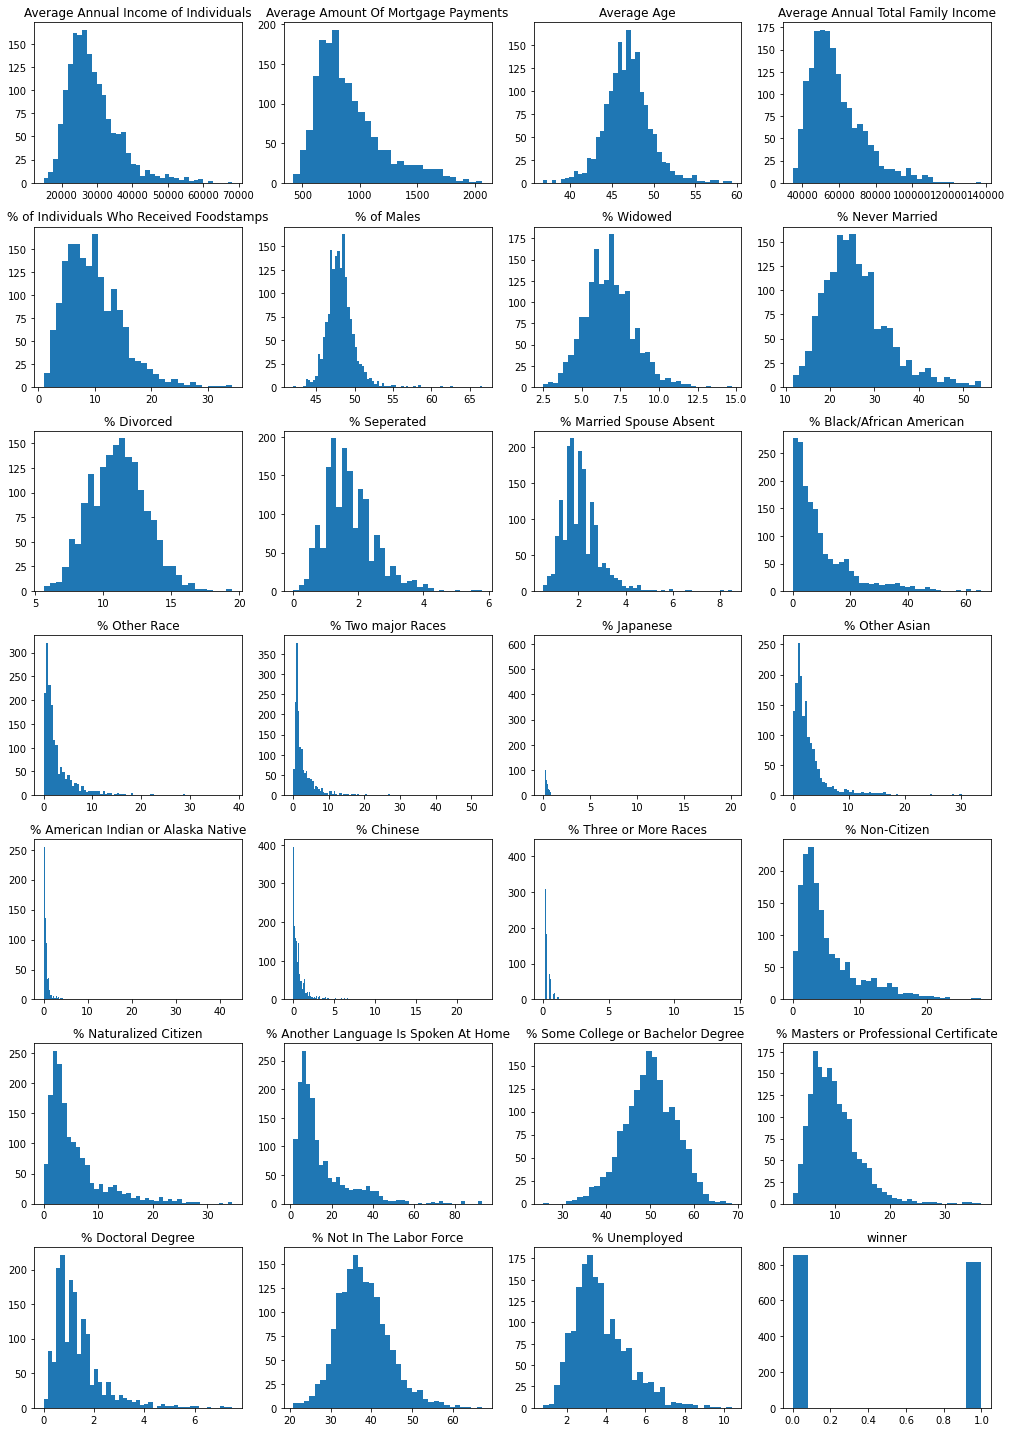

In [17]:
# set up figure for remaining predictor variables in pres_df_binary
fig, axes = plt.subplots(nrows=(pres_df_binary.shape[1] // 4), ncols=4, figsize=(14,20))

# for each col in pres_df_binary, plot distribution
for col, ax in zip(pres_df_binary, axes.flatten()):
    ax.hist(pres_df_binary[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

In [18]:
# checking skew
skew_dict = {col: pres_df_binary[col].skew() for col in pres_df_binary.columns}
sorted(skew_dict.items(), key = lambda x: x[1], reverse = True)

[('% Japanese', 14.225645376417823),
 ('% Three or More Races', 12.958995759654524),
 ('% American Indian or Alaska Native', 12.27393163370858),
 ('% Chinese', 6.117955414893402),
 ('% Two major Races', 4.431729634988505),
 ('% Other Asian', 3.528662241008241),
 ('% Other Race', 3.3196618422536543),
 ('% Another Language Is Spoken At Home', 2.1372927643249713),
 ('% Doctoral Degree', 2.0947227321666024),
 ('% Black/African American', 1.9984005385580035),
 ('% Naturalized Citizen', 1.957434023575899),
 ('% of Males', 1.8348877524676177),
 ('% Married Spouse Absent', 1.7166976573230215),
 ('% Non-Citizen', 1.6925120055089615),
 ('% Masters or Professional Certificate', 1.5473773140107256),
 ('Average Annual Income of Individuals', 1.3717823754930822),
 ('Average Annual Total Family Income', 1.2381474444602085),
 ('Average Amount Of Mortgage Payments', 1.1783968298185061),
 ('% of Individuals Who Received Foodstamps', 0.9988343531328995),
 ('% Unemployed', 0.9564741625539154),
 ('% Never 

It looks like most of our  variables are either normally distributed or skewed to the right. We can also see that we do not have a substantial class imbalance - the number of counties won by the Democrat (0) and Republican (1) are nearly equal. 

When the time comes to build our model, we'll need to scale and/or transform these columns to bring the orders of magnitude into line and ensure that the distributions are as close to normal as possible.

It also appears that our classes are pretty balanced:

In [19]:
pres_df_binary['winner'].value_counts(normalize = True)

0.0    0.511377
1.0    0.488623
Name: winner, dtype: float64

That's close to a 50/50 split. For a naive model that just predicts the majority class every time, we would expect an accuracy of about 51%.

Next, we'll use a heatmap to check to what correlations exist among our features.

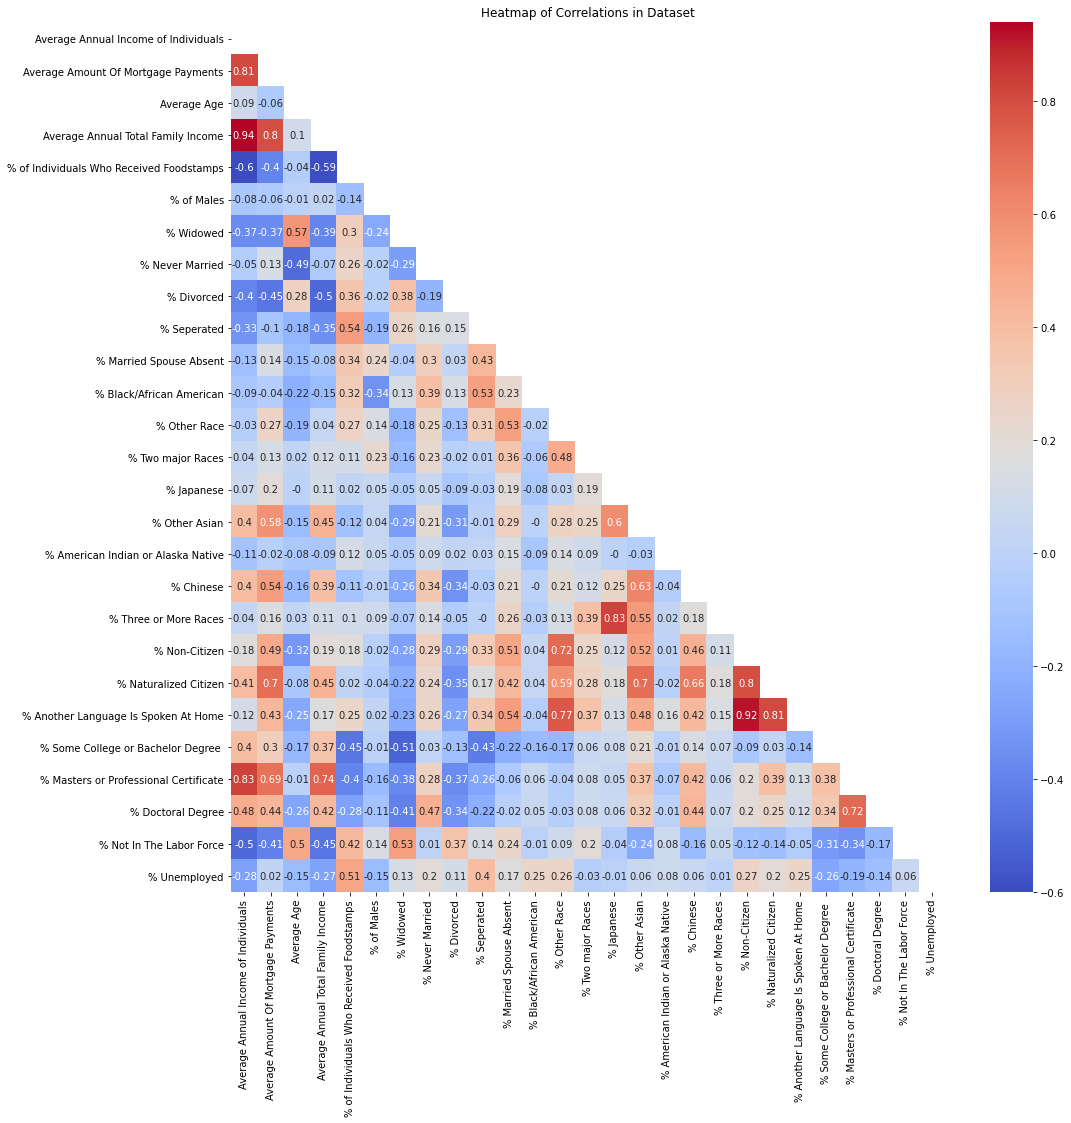

In [20]:
# instantiate figure
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = round(pres_df_binary.drop('winner', axis = 1).corr(), 2)

# create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot figure
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask)

# Customize the plot appearance
ax.set_title("Heatmap of Correlations in Dataset");

plt.show()

There are some notable correlations between categories (such as % Masters or Professional Certificate and Average Annual Income of Individuals, or % Another Language Is Spoken At Home and % Non-Citizen), and a relatively high degree of correlation among variables in the same category (as expected, since the values within each category have to sum to 100%). However, for now, we can hold off on removing any more columns from our dataset until we have a baseline model to evaluate and iterate on.

## Baseline Model: Logistic Regression
Let's begin by creating a baseline logistic regression model. This is an appropriate approach to begin with because we're trying to answer a binary classification question (Democrat or Republican). We'll start by splitting our data into train and test sets, with 25% of our rows set aside as a test set for evaluation. That will leave around 1200 rows for training our model, while preserving 400 to test its performance on unseen data to help us avoid overfitting and underfitting.

Our goal in building each model will be to maximize that model's recall. In the context of this question, a "false negative" means a district where the model predicted that the Democrats would lose a county that they expected to win - a result that may cost them a national election. As a secondary goal I prioritized accuracy, because each incorrect prediction in either direction may cost us valuable campaign dollars or electoral votes. For each model, I will report those metrics along with the model's precision and f1 score.

In [21]:
# separate X and y
X_full = pres_df_binary.drop('winner', axis = 1)
y_full = pres_df_binary['winner']

In [22]:
# split into train and test sets with a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, 
                                                    test_size = .25, 
                                                    random_state = 270)

In [23]:
# examine head of feature df
X_train.head()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed
1292,35446.8,1048.7,49.0,70306.8,9.9,47.9,7.1,31.1,10.5,1.0,2.1,10.7,5.1,6.6,0.1,4.5,0.2,0.6,0.5,6.0,10.7,21.2,48.2,15.9,2.0,38.6,3.6
228,28553.2,703.6,47.7,56406.1,4.1,48.6,7.8,20.0,11.9,1.5,1.5,0.9,0.2,1.1,0.1,0.1,0.1,0.4,0.0,0.6,2.4,4.1,51.7,11.2,0.6,30.0,3.6
298,21456.8,544.2,49.6,45210.0,6.2,49.9,10.7,22.0,10.5,2.2,2.1,3.0,0.1,0.5,0.0,0.6,0.0,0.0,0.0,0.6,1.0,4.4,31.1,5.4,0.8,41.9,2.4
36,33057.2,1546.5,44.3,64583.2,3.1,49.0,5.8,27.1,10.9,1.9,2.8,4.0,5.9,2.7,0.7,9.6,1.0,1.7,0.2,11.9,14.4,32.3,54.2,10.7,1.9,33.2,4.0
335,26268.5,758.5,44.7,56052.4,6.7,49.5,6.8,15.5,10.7,1.8,2.2,1.7,2.8,1.3,0.0,0.7,0.4,0.2,0.1,5.1,1.6,11.9,42.7,4.1,0.5,34.4,3.0


In [24]:
# 1 means the Republican won, 0 means the Democrat won
y_train.head()

1292    0.0
228     1.0
298     1.0
36      0.0
335     1.0
Name: winner, dtype: float64

In [25]:
# make sure nothing went wrong
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

We'll use a pipeline to minimize the risk of data leakage in our baseline, and use a standard scaler to transform the values to ensure they're all on the same order of magnitude. We'll also use a five fold cross validation to minimize the risk of overfitting on the training data.

In [26]:
# instantiate pipeline
baseline_pipe = Pipeline([('scaler', StandardScaler()),
                  ('lr', LogisticRegression(max_iter = 2000))])

# fit pipeline
baseline_pipe.fit(X_train, y_train)

# calculate mean cross validation recall score
baseline_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=5, scoring = 'recall')
print("Mean cross-validation recall score:", baseline_scores.mean())

Mean cross-validation recall score: 0.8351691581431944


Looks like our model is performing okay for now - about 83% accuracy on our validation folds. Let's see how it performs on test data.

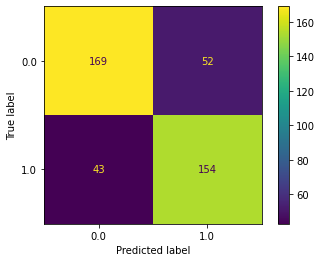

In [27]:
# generate predictions
y_baseline_preds = baseline_pipe.predict(X_test)

# plot confusion matrix
plot_confusion_matrix(baseline_pipe, X_test, y_test);

In [28]:
# print classification report for closer examination
print(classification_report(y_test, y_baseline_preds))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       221
         1.0       0.75      0.78      0.76       197

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418



Overall our baseline model performs okay on unseen data (and much better than the 51% we would expect from random predictions), but not nearly at the level we need to guide national campaign-level decision-making. We want to be accurate overall, but in the context of this model, a false negative (where we predicted that a county would vote Democratic but it voted Republican) is a much worse outcome for us than a false positive (where we predicted that a county would vote Republican but it voted Democratic). False positives may cost us money in campaign dollars, but false negatives can cost us elections!

Consequently, we're hoping to minimize our false negatives and maximize our recall. For this baseline, our accuracy and recall are both 77%, meaning only about 77% of our predicted outcomes are accurate and we're only capturing about 77% of the actual number of Republican victories in our data. That leaves a lot of room for surprise Republican victories that may upset our electoral plans. For subsequent models, we'll try different preprocessing and modeling techniques that may be able to increase these values. Let's make a table to keep track as we go:

In [29]:
# evaluation table courtesy of Burhan Y. Kiyakoglu
# https://www.kaggle.com/code/burhanykiyakoglu/predicting-house-prices
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Recall':[],
                           'Precision':[],
                           'F1':[]})

lr_prec = precision_score(y_test, y_baseline_preds)
lr_rec = recall_score(y_test, y_baseline_preds)
lr_acc = accuracy_score(y_test, y_baseline_preds)
lr_f1 = f1_score(y_test, y_baseline_preds)

evaluation.loc[0] = ['Baseline Logistic Regression',
                     '-',
                     lr_prec, lr_rec, lr_acc, lr_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268


## Model 1: Tuned Logistic Regression
Let's start by tuning the hyperparameters for the logistic regression to try to improve its performance. Since we want to be able to pull the most important features from our model, we'll use an l1 penalty to reduce the weights of less consequential features to effectively 0, and use a GridSearch to test potential regularization hyperparameters to try to avoid overfitting.

In [30]:
# instantiate lr and pipeline
lr_tuned_decision = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state= 42)
lr_tuned_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', lr_tuned_decision)])

# set parameters to search
lr_tuned_params = {'model__C': [.1, 1, 10, 100]}

# instantiate and fit grid search
lr_tuned_cv = GridSearchCV(estimator = lr_tuned_pipe, param_grid = lr_tuned_params, cv = 5, return_train_score=True)
lr_tuned_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.1, 1, 10, 100]},
             return_train_score=True)

In [31]:
# show cross validation results
lr_tuned_results = pd.DataFrame(lr_tuned_cv.cv_results_)
lr_tuned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005077,0.000280,0.001083,0.000086,0.1,{'model__C': 0.1},0.832669,0.820717,0.788,0.824,0.812,0.815477,0.015250,4,0.829171,0.825175,0.832335,0.817365,0.835329,0.827875,0.006243
1,0.010248,0.001111,0.001004,0.000050,1,{'model__C': 1},0.844622,0.828685,0.816,0.836,0.824,0.829861,0.009833,2,0.845155,0.840160,0.852295,0.844311,0.848303,0.846045,0.004065
2,0.011665,0.000994,0.001092,0.000094,10,{'model__C': 10},0.844622,0.824701,0.816,0.840,0.824,0.829865,0.010712,1,0.843157,0.843157,0.851297,0.841317,0.845309,0.844848,0.003464
3,0.010707,0.000363,0.001117,0.000052,100,{'model__C': 100},0.844622,0.824701,0.812,0.840,0.824,0.829065,0.011811,3,0.843157,0.843157,0.851297,0.842315,0.846307,0.845247,0.003319


It seems the model performs best on the validation folds with a regularization parameter of 10, so let's see how it performs with that hyperparameter on our test data.

In [32]:
# set the hyperparameters and make predictions on the test set
best_lr_tuned_model = lr_tuned_cv.best_estimator_
y_pred_lr_tuned = best_lr_tuned_model.predict(X_test)

In [33]:
# print the classification report
print(classification_report(y_test, y_pred_lr_tuned))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       221
         1.0       0.74      0.79      0.76       197

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418



Our recall increased about 1% from the untuned model, and the accuracy remained about the same.

In [34]:
# calculate performance metrics and add to evaluation table
lr_tuned_prec = precision_score(y_test, y_pred_lr_tuned)
lr_tuned_rec = recall_score(y_test, y_pred_lr_tuned)
lr_tuned_acc = accuracy_score(y_test, y_pred_lr_tuned)
lr_tuned_f1 = f1_score(y_test, y_pred_lr_tuned)

evaluation.loc[1] = ['Tuned Logistic Regression',
                     'C = 10',
                     lr_tuned_prec, lr_tuned_rec, lr_tuned_acc, lr_tuned_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547


We can also pull the coefficients for the variables to see which have the greatest impact on our predictions:

In [35]:
best_lr_tuned_model[1]

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [36]:
# create dataframe to show coefficients for top 5 most impactful features
lr_features = pd.DataFrame(zip(X_train.columns, np.transpose(best_lr_tuned_model[1].coef_)), 
                           columns=['features', 'coef'])
lr_features.sort_values('coef').head()

,features,coef
14,% Japanese,[-1.9481143709781372]
7,% Never Married,[-1.8360103527475586]
0,Average Annual Income of Individuals,[-1.143023529425096]
21,% Another Language Is Spoken At Home,[-1.0686204014307414]
18,% Three or More Races,[-0.892041782777155]


In [37]:
lr_features.sort_values('coef', ascending = False).head()

,features,coef
3,Average Annual Total Family Income,[2.0099949148366294]
25,% Not In The Labor Force,[1.5356889975980754]
17,% Chinese,[0.6484582703156687]
19,% Non-Citizen,[0.5583720102139405]
22,% Some College or Bachelor Degree,[0.34398895947622715]


Since a Republican win is classified as our positive outcome, that means that positive coefficients are indicators that a higher value of that variable is associated with a greater likelihood of a Republican win, while a negative coefficient indicates that a given feature is associated with a greater likelihood of a Democratic win. We'll need to do more analysis to determine the importance of these coefficients, particularly given that we know there may be some multicollinearity among the features.

## Model 2: Decision Tree

Let's test a few more baseline models before we hone in on one to tune. We'll try a decision tree next - decision trees are great for complex datasets because it splits the data one feature at a time, which will also help us to identify which features are the most important in making predictions about the partisan outcome of a county. We'll use Gini inpurity to measure information gain because we want to heavily penalize heterogeneity in our leaves.

In [38]:
# instantiate and fit basic tree
baseline_tree = DecisionTreeClassifier(criterion = 'gini', random_state = 270)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=270)

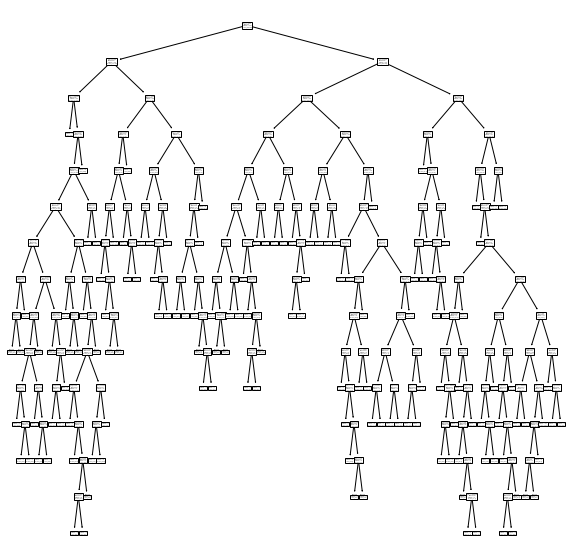

In [39]:
# instantiate figure and plot tree
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(baseline_tree, ax=ax);

With a depth of 15, this model is far too complex and almost certainly overfit. Let's check the scores on the train and test data to see.

In [40]:
# make predictions with decision tree
y_train_pred = baseline_tree.predict(X_train)
y_test_pred = baseline_tree.predict(X_test)

print('Baseline accuracy: ', baseline_tree.score(X_train, y_train))
print('Test accuracy: ', baseline_tree.score(X_test, y_test))
print('')
print('Baseline recall: ', recall_score(y_train, y_train_pred))
print('Test recall: ', recall_score(y_test, y_test_pred))

Baseline accuracy:  1.0
Test accuracy:  0.7559808612440191

Baseline recall:  1.0
Test recall:  0.766497461928934


As expected, this model performs much worse on unseen data than on the training data for our key metrics. Let's try pruning it by reducing the max depth to improve our performance on the test set.

In [41]:
# instantiate pipeline
pruned_pipe = Pipeline([('scaler', StandardScaler()),
                        ('tree', DecisionTreeClassifier(criterion = 'gini', random_state = 270))])

# parameter grid
pruned_parameters = {'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

# instantiate grid search
gs_pruned_pipe = GridSearchCV(estimator = pruned_pipe,
                                param_grid = pruned_parameters,
                                cv = 5)

In [42]:
# fit gridsearch on training data
gs_pruned_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=270))]),
             param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [43]:
# show cross validation results for pruned tree
grid_pruned_results = pd.DataFrame(gs_pruned_pipe.cv_results_)
grid_pruned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004854,0.000217,0.001010,0.000096,2,{'tree__max_depth': 2},0.756972,0.733068,0.712,0.740,0.684,0.725208,0.025148,9
1,0.005446,0.000039,0.000901,0.000043,3,{'tree__max_depth': 3},0.752988,0.784861,0.740,0.788,0.776,0.768370,0.018745,2
2,0.006549,0.000088,0.000913,0.000042,4,{'tree__max_depth': 4},0.756972,0.749004,0.780,0.784,0.772,0.768395,0.013399,1
3,0.007546,0.000042,0.000881,0.000012,5,{'tree__max_depth': 5},0.760956,0.772908,0.732,0.776,0.748,0.757973,0.016316,7
4,0.008581,0.000038,0.000893,0.000021,6,{'tree__max_depth': 6},0.760956,0.772908,0.768,0.780,0.752,0.766773,0.009656,3
5,0.009580,0.000190,0.000903,0.000041,7,{'tree__max_depth': 7},0.780876,0.756972,0.744,0.784,0.736,0.760370,0.019247,4
6,0.010289,0.000087,0.000880,0.000006,8,{'tree__max_depth': 8},0.792829,0.772908,0.736,0.760,0.736,0.759547,0.021888,6
7,0.010887,0.000160,0.000880,0.000005,9,{'tree__max_depth': 9},0.784861,0.721116,0.748,0.764,0.724,0.748395,0.024136,8
8,0.011383,0.000245,0.000881,0.000004,10,{'tree__max_depth': 10},0.788845,0.752988,0.748,0.784,0.724,0.759567,0.024068,5


It seems like no matter where we prune the tree, there isn't a depth that is going to produce a strong result on unseen data. But somewhat surprisingly, the tree with a max depth of 4 performed the best on our test data. Perhaps we can utilize multiple simpler trees through a random forest model to take advantage of the power of an ensemble learning approach.

## Model 3: Random Forest

A random forest model uses numerous decision trees to essentially "vote" on each datapoint's likely class. By using the majority outcome of numerous decision trees, each of which uses a different subset of features in making an individual prediction, it can reduce the errors that result from trying to apply a single decision tree to a dataset.

For this model, we'll use 250 trees and test a variety of max tree depths to see which provides the best result.

In [44]:
# instantiate random forest and pipeline
rf_decision = RandomForestClassifier(n_estimators = 250, random_state = 42)
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', rf_decision)])
rf_params = {'model__max_depth': np.arange(2,11,1)}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = rf_params, cv = 5, scoring = 'recall', return_train_score=True)

In [45]:
# fit the random forest on the training data
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(n_estimators=250,
                                                               random_state=42))]),
             param_grid={'model__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True, scoring='recall')

In [46]:
# report the best recall score from the validation folds
rf_cv.best_score_

0.8626409651193286

In [47]:
# display the cross validation results as a dataframe
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.237072,0.001445,0.028822,0.032991,2,{'model__max_depth': 2},0.790323,0.846774,0.837398,0.814516,0.822581,0.822318,0.019546,9,0.850505,0.848485,0.850806,0.842424,0.836364,0.845717,0.005564
1,0.271515,0.002213,0.012550,0.000173,3,{'model__max_depth': 3},0.798387,0.854839,0.853659,0.846774,0.822581,0.835248,0.021794,8,0.874747,0.874747,0.870968,0.862626,0.864646,0.869547,0.005060
2,0.305667,0.001134,0.012920,0.000265,4,{'model__max_depth': 4},0.838710,0.854839,0.845528,0.870968,0.838710,0.849751,0.012146,5,0.905051,0.892929,0.915323,0.886869,0.903030,0.900640,0.009898
3,0.340066,0.001850,0.013544,0.000267,5,{'model__max_depth': 5},0.846774,0.870968,0.837398,0.854839,0.830645,0.848125,0.014066,6,0.927273,0.907071,0.925403,0.911111,0.915152,0.917202,0.007907
4,0.370470,0.000788,0.013849,0.000124,6,{'model__max_depth': 6},0.854839,0.862903,0.837398,0.895161,0.838710,0.857802,0.021030,4,0.943434,0.927273,0.943548,0.923232,0.933333,0.934164,0.008267
5,0.397889,0.000523,0.014280,0.000156,7,{'model__max_depth': 7},0.862903,0.854839,0.837398,0.862903,0.822581,0.848125,0.015808,7,0.955556,0.957576,0.949597,0.949495,0.951515,0.952748,0.003263
6,0.421201,0.001442,0.014821,0.000141,8,{'model__max_depth': 8},0.870968,0.879032,0.837398,0.895161,0.830645,0.862641,0.024724,1,0.973737,0.971717,0.973790,0.967677,0.977778,0.972940,0.003285
7,0.441542,0.007179,0.015097,0.000243,9,{'model__max_depth': 9},0.846774,0.870968,0.837398,0.903226,0.838710,0.859415,0.025004,2,0.987879,0.991919,0.987903,0.983838,0.989899,0.988288,0.002679
8,0.472996,0.011256,0.016282,0.000613,10,{'model__max_depth': 10},0.862903,0.870968,0.837398,0.903226,0.822581,0.859415,0.027952,2,0.993939,0.997980,0.993952,1.000000,1.000000,0.997174,0.002737


It looks like for our random forest with a max depth of 8 produces the best score on our validation folds, but based on the scores on the training folds that model looks like it's very overfit. Instead, let's try the model with a max depth of 4, which produces relatively close results for the training and validation folds.

In [48]:
# manually instantiate rf model
best_rf_model = RandomForestClassifier(n_estimators = 250, random_state= 42, max_depth = 4)

# fit on training data
best_rf_model.fit(X_train, y_train)

# make predictions and show classification report
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       221
         1.0       0.76      0.79      0.77       197

    accuracy                           0.78       418
   macro avg       0.78      0.78      0.78       418
weighted avg       0.78      0.78      0.78       418



We've improved our performance on test data to about 78% for both accuracy and recall. Let's compare the random forest to our original logistic regression model.

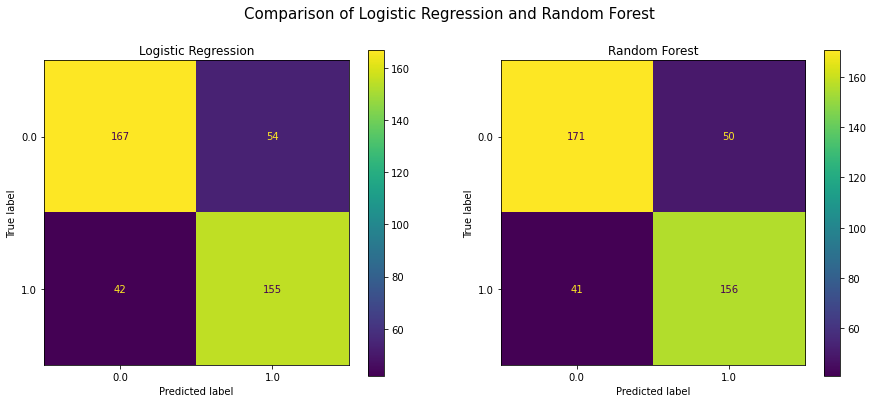

In [49]:
# instantiate figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression and Random Forest', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")

# plot confusion matrices for lr and rf models
plot_confusion_matrix(best_lr_tuned_model, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1]);

In [50]:
# calculate scores
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

# add to eval table
evaluation.loc[2] = ['Tuned Random Forest',
                     'Max Depth = 4',
                     rf_prec, rf_rec, rf_acc, rf_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194


We can see marginal improvements across the board in accuracy for this model compared to the tuned logistic regression - the recall jumped about .5%, and the accuracy increased nearly 1%. Let's see what the most important features were for this model:

In [51]:
# pull feature importances attribute
feat_imp = best_rf_model.feature_importances_

# show importances and category
feat_imp_series = pd.Series(feat_imp, 
          index = X_train.columns).sort_values(
    ascending = False)

feat_imp_series

% Never Married                             0.238853
% Chinese                                   0.139327
% Other Asian                               0.082715
% Naturalized Citizen                       0.079074
% Masters or Professional Certificate       0.067037
% Doctoral Degree                           0.058968
% Non-Citizen                               0.044957
% Black/African American                    0.041190
% Another Language Is Spoken At Home        0.036591
Average Amount Of Mortgage Payments         0.034482
% Unemployed                                0.025607
Average Age                                 0.021661
% Not In The Labor Force                    0.019739
% of Individuals Who Received Foodstamps    0.015750
% of Males                                  0.013762
Average Annual Income of Individuals        0.009552
% Some College or Bachelor Degree           0.009001
% Other Race                                0.008548
Average Annual Total Family Income          0.

Interestingly, these categories differ significantly from the most heavily weighted categories in the logistic regression. We can examine the feature importances of a few more models before drawing any conclusions.

## Model 4: XGBoost

Like a random forest model, an Extreme Gradiest Boosting (XGBoost) model uses an ensemble learning approach to start with a weak model and "learn" iteratively by using lots of progressively stronger decision trees and weighting the predictions of each tree to reach a final classification prediction for each row of data. For this model, we'll set an identical max depth to that for the random forest, and use a high value for the minimum loss reduction parameter (gamma) and miniumum child weight to avoid overfitting. We'll use a grid search to identify the best learning rate and number of trees.

In [52]:
# instantiate model, parameters, and grid search
xg_params = {'learning_rate': [.01, .1], 'n_estimators': [200,400]}
xg_cv = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', random_state = 270, 
                                               gamma = 10, max_depth = 4, min_child_weight = 4), 
                     scoring='recall', param_grid = xg_params, cv = 5, return_train_score=True)

# fit grid search
xg_cv.fit(X_train, y_train);

In [53]:
# display cross validation results as dataframe
pd.DataFrame(xg_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.385695,0.033708,0.002613,0.000515,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.822581,0.846774,0.821138,0.879032,0.806452,0.835195,0.025451,2,0.884848,0.866667,0.881048,0.870707,0.872727,0.875200,0.006729
1,0.662508,0.053395,0.002499,0.000226,0.01,400,"{'learning_rate': 0.01, 'n_estimators': 400}",0.822581,0.854839,0.821138,0.887097,0.806452,0.838421,0.029019,1,0.886869,0.872727,0.883065,0.874747,0.874747,0.878431,0.005520
2,0.294798,0.039551,0.002304,0.000739,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.822581,0.846774,0.813008,0.879032,0.806452,0.833569,0.026533,3,0.886869,0.868687,0.885081,0.870707,0.874747,0.877218,0.007433
3,0.547354,0.040262,0.002026,0.000121,0.1,400,"{'learning_rate': 0.1, 'n_estimators': 400}",0.822581,0.846774,0.813008,0.879032,0.806452,0.833569,0.026533,3,0.886869,0.868687,0.885081,0.870707,0.874747,0.877218,0.007433


In [54]:
# show parameters for best cross validation results on validation folds
xg_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=270,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
# set model hyperparameters to those of model with best cross val results
best_xg_model = xg_cv.best_estimator_

# make predictions on test data
y_pred_xg = best_xg_model.predict(X_test)

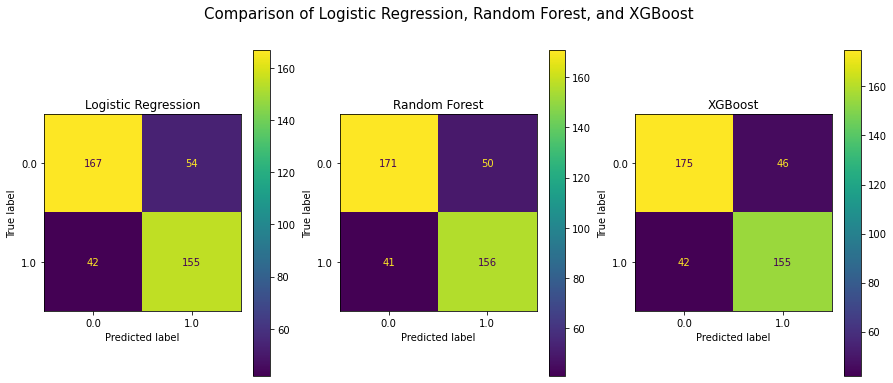

In [56]:
# instantiate figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression, Random Forest, and XGBoost', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")
axes[2].set_title("XGBoost")

# plot confusion matrices for lr, rf, and xg models
plot_confusion_matrix(best_lr_tuned_model, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1])
plot_confusion_matrix(best_xg_model, X_test, y_test, ax=axes[2]);

In [57]:
# add xgboost performance metrics to evaluation table
xg_prec = precision_score(y_test, y_pred_xg)
xg_rec = recall_score(y_test, y_pred_xg)
xg_acc = accuracy_score(y_test, y_pred_xg)
xg_f1 = f1_score(y_test, y_pred_xg)

evaluation.loc[3] = ['Tuned XGBoost',
                     'Estimators = 400, Learning Rate = .01',
                     xg_prec, xg_rec, xg_acc, xg_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894


It looks like the XGBoost is performing nearly identically to the random forest. It has a slightly lower recall (.5%), but slightly higher accuracy (1.5%) and precision (.7%). For now it's probably our best model, but we have more approaches to test before reaching a final model.

How do the feature importances from this model compare to those of the random forest and logistic regression?

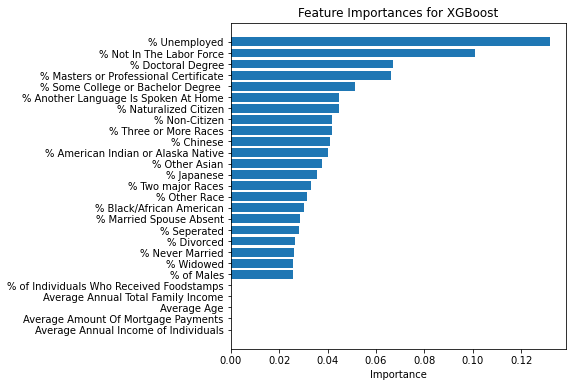

In [58]:
# instantiate figure and axis
fig, ax = plt.subplots(figsize = (6, 6))

# plot feature importances from the XGBoost model as a horizontal bar chart
plt.barh(X_train.columns, sorted(best_xg_model.feature_importances_));

ax.set_title('Feature Importances for XGBoost')
ax.set_xlabel('Importance');

This is yet another different answer from the previous two models - the top two most important features in this model are both related to employment status.

## Reducing Dimensionality and Rerunning Models

One thing that is clear from looking at the feature importances of the preceding models is that a lot of our feature categories could be reduced to two columns: a "default" column, and a "not default" column. Let's manually reduce the number of columns in our model to reduce multicollinearity, and try running each of our models again.

In [59]:
# start by making a copy of original dataframe with only presidential years
pres_df_reduced = census_data[census_data['year'].isin(pres_years)]
pres_df_reduced

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
1528,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,56.4,12.4,2.6,1.8,77.0,20.0,0.6,1.0,0.1,0.5,0.6,0.1,0.1,97.0,1.9,1.0,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [60]:
# drop rows with null values
pres_df_reduced.dropna(inplace = True)
pres_df_reduced.reset_index(drop = True, inplace = True)
pres_df_reduced

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2020,55105,25993.3,657.3,49.1,54440.5,91.6,8.4,51.3,48.7,7.4,27.4,49.9,13.0,0.4,1.9,89.4,3.3,1.3,4.4,0.1,0.2,0.3,0.4,0.5,96.2,1.1,2.7,96.6,3.4,51.4,40.3,7.4,0.8,53.4,43.2,3.4,WI,ROCK,46658.0,14.0,1094.0,456.0,37138.0,0.0
1666,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1667,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1668,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0


In [61]:
# drop vote count columns
pres_df_reduced.drop(votecounts, inplace = True, axis = 1)
pres_df_reduced.head(2)

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,1.0


In order to reduce the dimensionality and multicollinearity of the data, we can combine columns so that there are only two values in each category: the "default" value that we dropped during our original analysis (which we'll drop again here), and a "not default" value that combines every other category. We'll also drop the average total individual income column, since it is highly correlated with the family income column.

In [62]:
default = ['year',                     # year
          'county_fips',              # unique county identifier
          'inctot',                   # average total income of individuals
          'foodstmp_1_freq',          # % not on foodstamps
          'sex_2_freq',               # % female
          'marst_1_freq',             # % married spouse present
          'race_1_freq',              # % white
          'ctz_stat_1_freq',          # % natural citizen
          'lang_1_freq',              # % speak english at home
          'educ_attain_1.0_freq',     # % high school or lower education
          'empstat_1.0_freq',         # % employed
          'state_po',                 # state postal abbreviation
          'county_name']

pres_df_reduced.drop(default, axis = 1, inplace = True)
pres_df_reduced.head(2)

,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,51.8,8.4,0.5,43.5,2.4,1.0
1,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,41.1,5.0,1.2,41.1,4.5,1.0


Now we need to sum the remaining columns in each category to create our "not default" column. We can do so with a function and a list of the relevant columns:

In [63]:
def sum_columns(df, cols, newcol):
    '''
    A function that takes three arguments: a dataframe, a list of columns,
    and a string with a new column name. Sums the values of each row across the
    columns specified, and returns that value as a new column in the dataframe.
    '''
    df[newcol] = df[cols].sum(axis = 1)
    return df[newcol]

In [64]:
# list comprehension to get columns from the same categories
marriage_cols = [col for col in pres_df_reduced.columns if col.startswith('marst')]
race_cols = [col for col in pres_df_reduced.columns if col.startswith('race')]
citizen_cols = [col for col in pres_df_reduced.columns if col.startswith('ctz')]
education_cols = [col for col in pres_df_reduced.columns if col.startswith('educ')]
employment_cols = [col for col in pres_df_reduced.columns if col.startswith('emp')]

# concatenated list of all individual columns that are being condensed
oldcols_todrop = marriage_cols + race_cols + citizen_cols + education_cols + employment_cols

In [65]:
# run function to sum constituent columns
sum_columns(pres_df_reduced, marriage_cols, '% Non Spouse Present')
sum_columns(pres_df_reduced, race_cols, '% Nonwhite')
sum_columns(pres_df_reduced, citizen_cols, '% Non Natural Citizen')
sum_columns(pres_df_reduced, education_cols, '% Some College Plus')
sum_columns(pres_df_reduced, employment_cols, '% Not Employed')

0       45.9
1       45.6
2       49.7
3       41.5
4       40.1
        ... 
1665    46.6
1666    43.7
1667    38.4
1668    39.3
1669    43.1
Name: % Not Employed, Length: 1670, dtype: float64

In [66]:
# dro pconstituent columns
pres_df_reduced.drop(oldcols_todrop, axis = 1, inplace = True)

In [67]:
# rename columns for readability
pres_df_reduced.rename(columns=descriptions_dict, inplace=True)
pres_df_reduced

,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Another Language Is Spoken At Home,winner,% Non Spouse Present,% Nonwhite,% Non Natural Citizen,% Some College Plus,% Not Employed
0,902.2,48.6,53308.6,5.8,47.5,2.9,1.0,36.5,8.8,2.9,60.7,45.9
1,551.7,47.1,39712.5,10.9,45.2,4.6,1.0,45.5,19.4,2.7,47.3,45.6
2,658.6,48.2,47650.0,5.8,45.4,2.0,1.0,39.1,14.4,1.4,53.4,49.7
3,812.4,47.2,54993.2,6.5,45.0,3.4,0.0,49.7,36.9,2.5,58.0,41.5
4,725.1,40.6,45575.0,7.6,47.9,6.8,1.0,49.0,25.0,5.6,67.8,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...
1665,657.3,49.1,54440.5,8.4,48.7,3.4,0.0,50.1,10.5,3.8,59.6,46.6
1666,704.0,50.3,52592.7,4.4,50.5,5.6,1.0,42.9,10.2,3.5,59.3,43.7
1667,846.0,49.0,63315.2,5.1,50.6,8.6,1.0,43.4,8.4,6.8,66.9,38.4
1668,990.6,50.4,80433.1,4.1,47.2,6.9,1.0,38.5,8.8,5.6,73.5,39.3


In [68]:
print(f'The original dataframe had {X_train.shape[1]} columns.')
print(f'The reduced dimensionality dataframe has {pres_df_reduced.shape[1] - 1} columns.')

The original dataframe had 27 columns.
The reduced dimensionality dataframe has 11 columns.


We succeeded in reducing the dimensionality of our data by over half! Let's look at the distributions of the new columns:

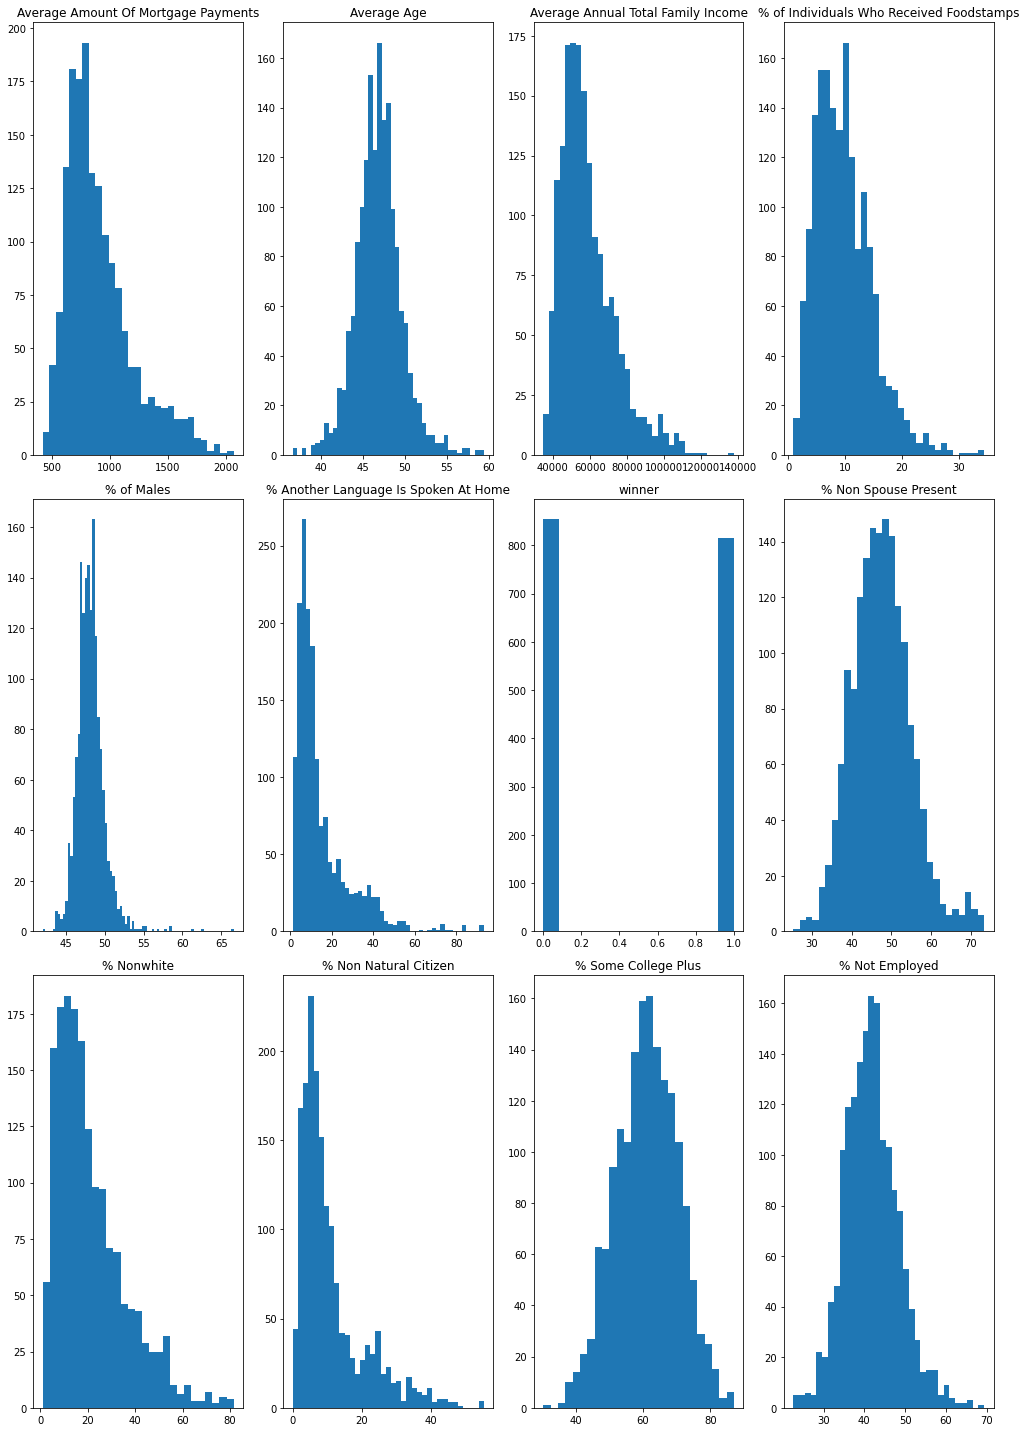

In [69]:
# set up figure for remaining predictor variables in X_third
fig, axes = plt.subplots(nrows=(pres_df_reduced.shape[1] // 4), ncols=4, figsize=(14,20))

# for each col in pres_df_binary, plot distribution
for col, ax in zip(pres_df_reduced, axes.flatten()):
    ax.hist(pres_df_reduced[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

In [70]:
# checking skew
skew_dict_reduced = {col: pres_df_reduced[col].skew() for col in pres_df_reduced.columns}
sorted(skew_dict_reduced.items(), key = lambda x: x[1], reverse = True)

[('% Another Language Is Spoken At Home', 2.1372927643249713),
 ('% of Males', 1.8348877524676177),
 ('% Non Natural Citizen', 1.661418672717671),
 ('Average Annual Total Family Income', 1.2381474444602085),
 ('% Nonwhite', 1.2352146871328245),
 ('Average Amount Of Mortgage Payments', 1.1783968298185061),
 ('% of Individuals Who Received Foodstamps', 0.9988343531328995),
 ('% Non Spouse Present', 0.4484360326419896),
 ('% Not Employed', 0.4029961993206743),
 ('Average Age', 0.3690489370924486),
 ('winner', 0.04556170203360654),
 ('% Some College Plus', -0.07057215395380777)]

Again, appear to be either normally distributed, with the skew values having been reduced from the original dataset as well. We can check the descriptive statistics for each column as well:

In [71]:
pres_df_reduced.describe()

,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Another Language Is Spoken At Home,winner,% Non Spouse Present,% Nonwhite,% Non Natural Citizen,% Some College Plus,% Not Employed
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,906.672635,46.903772,58749.243473,9.748743,48.144371,14.897665,0.488623,47.503174,21.264251,11.030240,61.117904,41.774611
std,291.128525,2.787388,14606.621299,4.952513,1.830548,13.393902,0.500020,7.510950,14.650507,9.456712,9.209408,6.556944
min,421.100000,36.700000,34914.700000,0.900000,42.000000,1.400000,0.000000,25.300000,1.000000,0.100000,30.300000,22.600000
25%,698.025000,45.200000,48357.400000,6.100000,47.100000,6.200000,0.000000,42.400000,10.300000,4.700000,54.500000,37.200000
50%,828.550000,46.900000,55458.800000,9.100000,48.000000,10.100000,0.000000,47.150000,17.400000,7.800000,61.200000,41.300000
75%,1039.600000,48.400000,66187.150000,12.700000,49.000000,18.600000,1.000000,52.000000,28.575000,13.600000,67.700000,45.700000
max,2064.600000,59.400000,137573.700000,34.400000,66.600000,93.100000,1.000000,73.300000,81.500000,55.200000,87.000000,69.300000


And a heatmap to check for multicollinearity:

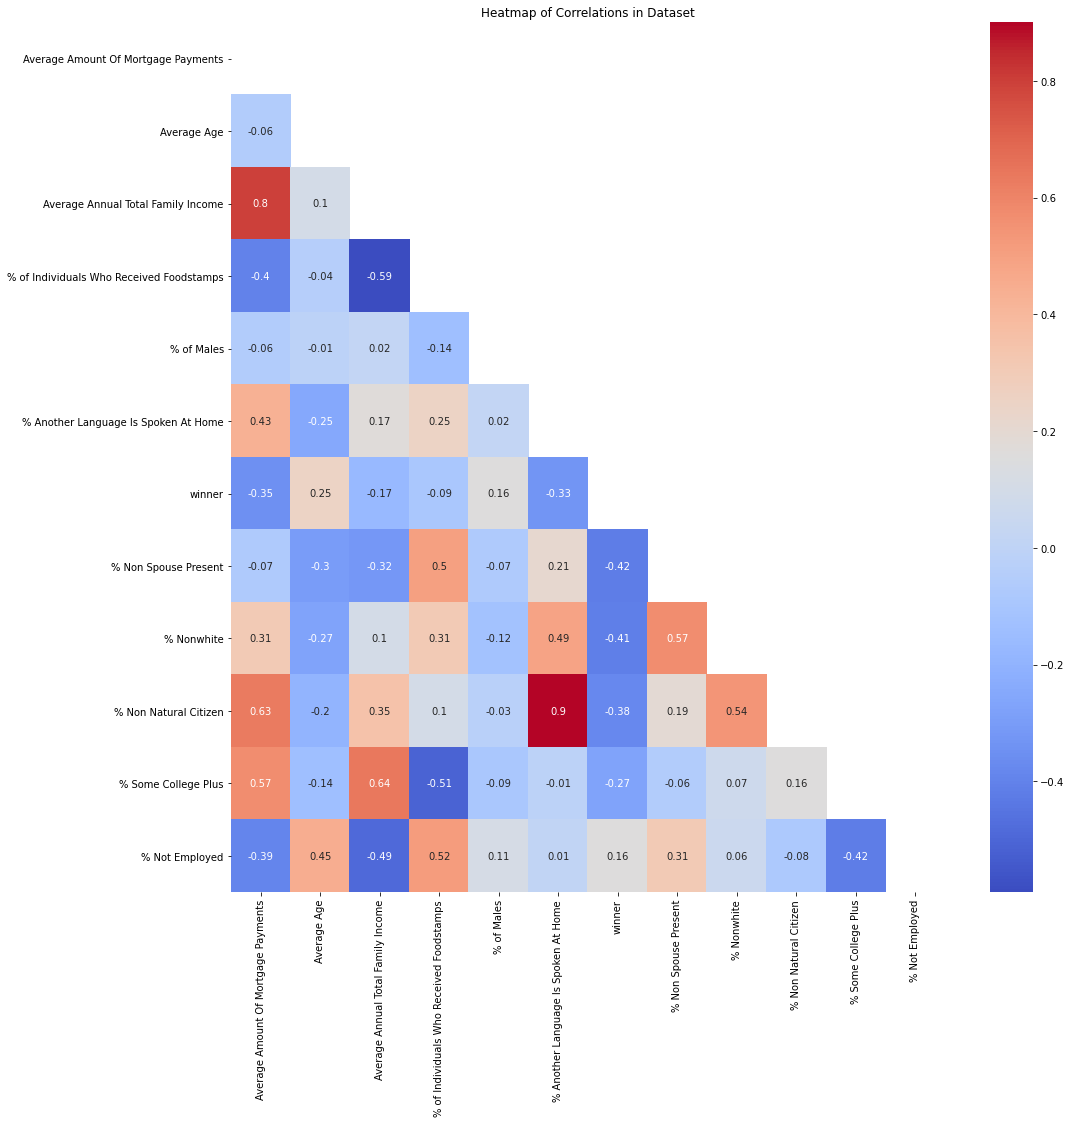

In [72]:
# instantiate figure
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = round(pres_df_reduced.corr(), 2)

# create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot figure
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask)

# Customize the plot appearance
ax.set_title("Heatmap of Correlations in Dataset");

plt.show()

While there are a few highly correlated variables (% non-natural-citizens and % not english spoken at home, or the income categories and average mortgage amount) we seem to be doing okay there as well. Let's quickly re-run each model with these features to see if it affects their performance.

### Reduced Dimensionality Logistic Regression

In [73]:
# separate X and y
X = pres_df_reduced.drop('winner', axis = 1)
y = pres_df_reduced['winner']

# split into train and test sets with a random state for reproducibility
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 270)

In [74]:
# instantiate pipeline and parameter grid
lr_tuned_decision_reduced = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state= 42)
lr_tuned_pipe_reduced = Pipeline([('scaler', StandardScaler()), ('model', lr_tuned_decision_reduced)])
lr_tuned_params_reduced = {'model__C': [.1, 1, 10, 100]}
lr_tuned_cv_reduced = GridSearchCV(estimator = lr_tuned_pipe, param_grid = lr_tuned_params, 
                           cv = 5, return_train_score=True)

# fit pipeline
lr_tuned_cv_reduced.fit(X_train_reduced, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.1, 1, 10, 100]},
             return_train_score=True)

In [75]:
# create model using best hyperparamters
best_lr_reduced_model = lr_tuned_cv_reduced.best_estimator_
lr_tuned_cv_reduced.best_params_

{'model__C': 10}

In [76]:
# generate predictions
y_lr_tuned_reduced_preds = best_lr_reduced_model.predict(X_test_reduced)

In [77]:
# calculate performance metrics and add to evaluation table
lr_prec_reduced = precision_score(y_test, y_lr_tuned_reduced_preds)
lr_rec_reduced = recall_score(y_test, y_lr_tuned_reduced_preds)
lr_acc_reduced = accuracy_score(y_test, y_lr_tuned_reduced_preds)
lr_f1_reduced = f1_score(y_test, y_lr_tuned_reduced_preds)

evaluation.loc[4] = ['Tuned Linear Regression - Reduced Data',
                     'C = 10',
                     lr_prec_reduced, lr_rec_reduced, lr_acc_reduced, lr_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000


In [78]:
# create dataframe to show coefficients for top 5 most impactful features
lr_reduced_features = pd.DataFrame(zip(X_train_reduced.columns, np.transpose(best_lr_reduced_model[1].coef_)), 
                           columns=['features', 'coef'])
lr_reduced_features.sort_values('coef').head()

,features,coef
6,% Non Spouse Present,[-1.8938143157125111]
0,Average Amount Of Mortgage Payments,[-1.0840613833180595]
8,% Non Natural Citizen,[-0.5538233618635777]
3,% of Individuals Who Received Foodstamps,[-0.49860719450300056]
9,% Some College Plus,[-0.463475052522321]


In [79]:
lr_reduced_features.sort_values('coef', ascending = False).head()

,features,coef
10,% Not Employed,[1.2993450005539913]
2,Average Annual Total Family Income,[0.5059583987997366]
4,% of Males,[0.16828077772464145]
5,% Another Language Is Spoken At Home,[-0.05389354481426658]
7,% Nonwhite,[-0.07187287393804619]


Interestingly, there are only three features with positive coefficients in this dataset - % who aren't employed (which includes retirees, who would be classified as not being in the labor force), average annual total family income, and % of males. That % Not Employed coefficient is particularly eye-catching, since it means that a one standard deviation increase (about 6.5 percentage points) in the percentage of the population that is not employed corresponds to a roughly 1.3 increase in the log odds of a Republican victory. Let's change that into percentage terms:

In [80]:
# start with a 50/50 outcome - roughly the probability of a Republican win 
#(i.e., probability of success / probability of failure = 0.5 / 0.5 = 1)
original_odds = 1

# calculate the odds ratio corresponding to a 1.3 increase in the log odds
odds_ratio = math.exp(1.3)

# calculate the new odds
new_odds = original_odds * odds_ratio

# calculate the new probability
new_probability = new_odds / (new_odds + 1)

print(f"The probability of a Republican victory after a 1.3 increase in the log odds is approximately {new_probability:.3f}")

The probability of a Republican victory after a 1.3 increase in the log odds is approximately 0.786


So holding all other factors constant, a 6.5 percentage point increase in the  is associated with an over 28 percentage point increase in the likelihood of a Republican victory! Intuitively that makes sense - retirees are included in this category and make up a substantial part of the Republican base. 

This leads to my first recommendation: **keep a close eye on counties where a large proportion of the population is not employed, because it may be an indicator that the county will vote Republican.**

### Reduced Dimensionality Random Forest

In [81]:
# instantiate random forest and pipeline
rf_reduced_decision = RandomForestClassifier(n_estimators = 250, random_state= 42, max_depth = 4)
rf_reduced_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', rf_reduced_decision)])

In [82]:
# fit pipeline to training data
rf_reduced_pipe.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=4, n_estimators=250,
                                        random_state=42))])

In [83]:
# make predictions
y_rf_reduced_preds = rf_reduced_pipe.predict(X_test_reduced)

In [84]:
# calculate and display feature importances
feat_imp_rf_red = rf_reduced_pipe[1].feature_importances_

feat_imp_series_red = pd.Series(feat_imp_rf_red, 
          index = X_train_reduced.columns).sort_values(
    ascending = False)

feat_imp_series_red

% Non Spouse Present                        0.254080
% Nonwhite                                  0.178171
% Non Natural Citizen                       0.128836
Average Amount Of Mortgage Payments         0.114347
% Another Language Is Spoken At Home        0.082912
% Some College Plus                         0.064020
% Not Employed                              0.055204
Average Age                                 0.053211
% of Individuals Who Received Foodstamps    0.023916
% of Males                                  0.023134
Average Annual Total Family Income          0.022168
dtype: float64

There isn't much overlap

In [85]:
# calculate performance metrics and add to evaluation table
rf_prec_reduced = precision_score(y_test, y_rf_reduced_preds)
rf_rec_reduced = recall_score(y_test, y_rf_reduced_preds)
rf_acc_reduced = accuracy_score(y_test, y_rf_reduced_preds)
rf_f1_reduced = f1_score(y_test, y_rf_reduced_preds)

evaluation.loc[5] = ['Tuned Random Forest - Reduced Data',
                     'Max Depth = 4',
                     rf_prec_reduced, rf_rec_reduced, rf_acc_reduced, rf_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305


### Reduced Dimensionality XGBoost

In [86]:
# instantiate parameters, pipeline, and grid search
xg_reduced_params = {'learning_rate': [.01, .1], 'n_estimators': [200,400]}
xg_reduced_cv = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', random_state = 270, 
                                               gamma = 10, max_depth = 3, min_child_weight = 4), 
                     scoring='recall', param_grid = xg_params, cv = 5, return_train_score=True)

# fit grid search to training data
xg_reduced_cv.fit(X_train_reduced, y_train);

In [87]:
# turn cross validation results into a dataframe
pd.DataFrame(xg_reduced_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.225171,0.019705,0.002309,0.000340,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.838710,0.846774,0.837398,0.822581,0.766129,0.822318,0.029160,2,0.876768,0.876768,0.854839,0.844444,0.866667,0.863897,0.012645
1,0.450425,0.020648,0.002364,0.000154,0.01,400,"{'learning_rate': 0.01, 'n_estimators': 400}",0.838710,0.846774,0.837398,0.846774,0.782258,0.830383,0.024380,1,0.882828,0.876768,0.858871,0.858586,0.878788,0.871168,0.010343
2,0.214275,0.022494,0.001832,0.000088,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.822581,0.838710,0.821138,0.838710,0.774194,0.819066,0.023672,3,0.874747,0.872727,0.860887,0.854545,0.876768,0.867935,0.008676
3,0.445223,0.044718,0.001845,0.000198,0.1,400,"{'learning_rate': 0.1, 'n_estimators': 400}",0.822581,0.838710,0.821138,0.838710,0.774194,0.819066,0.023672,3,0.874747,0.872727,0.860887,0.854545,0.876768,0.867935,0.008676


In [88]:
# check best parameters based on cross validation
xg_reduced_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=270,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
# set model parameters, fit to the training data, and make predictions
best_xg_model_reduced = xg_reduced_cv.best_estimator_
y_pred_xg_reduced = best_xg_model_reduced.predict(X_test_reduced)

In [90]:
# calculate performance metrics and add them to evaluation table
xg_prec_reduced = precision_score(y_test, y_pred_xg_reduced)
xg_rec_reduced = recall_score(y_test, y_pred_xg_reduced)
xg_acc_reduced = accuracy_score(y_test, y_pred_xg_reduced)
xg_f1_reduced = f1_score(y_test, y_pred_xg_reduced)

evaluation.loc[6] = ['Tuned XGBoost - Reduced Data',
                     'Estimators = 400, Learning Rate = .01',
                     xg_prec_reduced, xg_rec_reduced, xg_acc_reduced, xg_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305
6,Tuned XGBoost - Reduced Data,"Estimators = 400, Learning Rate = .01",0.722488,0.766497,0.751196,0.743842


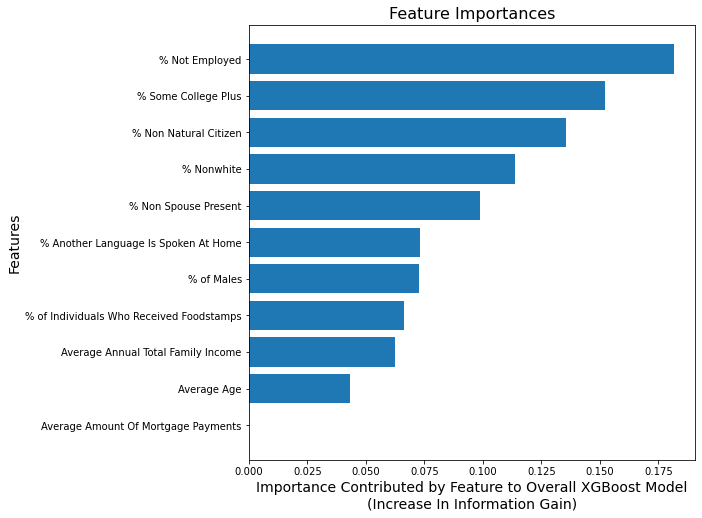

In [91]:
# instantitae the figure and axis
fig, ax = plt.subplots(figsize = (8, 8))

# plot the feature importance on a horizontal bar chart
plt.barh(X_train_reduced.columns, sorted(best_xg_model_reduced.feature_importances_))
ax.set_title('Feature Importances', fontsize = 16)
ax.set_xlabel('Importance Contributed by Feature to Overall XGBoost Model\n(Increase In Information Gain)', fontsize = 14)
ax.set_ylabel('Features', fontsize = 14);

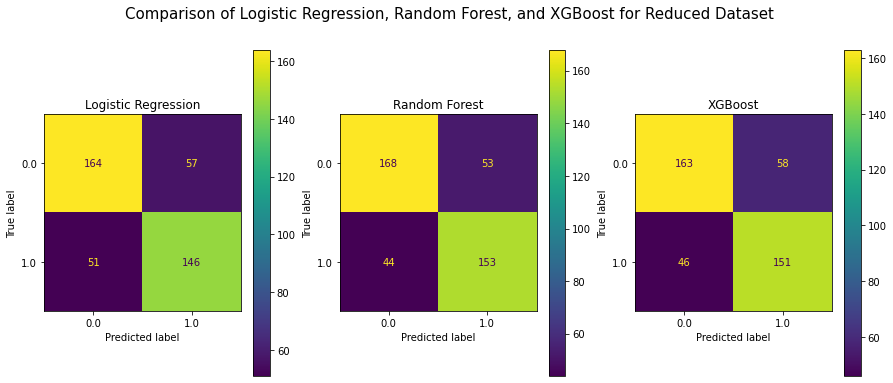

In [92]:
# instantiate the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression, Random Forest, and XGBoost for Reduced Dataset', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")
axes[2].set_title("XGBoost")

# plot the three primary confusion matrices side-by-side
plot_confusion_matrix(best_lr_reduced_model, X_test_reduced, y_test, ax=axes[0])
plot_confusion_matrix(rf_reduced_pipe, X_test_reduced, y_test, ax=axes[1])
plot_confusion_matrix(best_xg_model_reduced, X_test_reduced, y_test, ax=axes[2]);

So it looks like across the board, our models are performing somewhat worse with the reduced dataset. The XGBoost model with the full dataset is still the best model - it has the second best recall score (to the random forest model), with the highest accuracy. But with fewer features, we can try one additional approach - a K Nearest Neighbors model.

### Model 5: K Nearest Neighbors

A K Nearest Neighbors neighbor model makes predictions about the class of a given data point by comparing it to its "closest" known neighbors across the feature set. For making predictions about election outcomes, this may be a sensible approach - if two counties have similar demographic compositions, they may be likely to vote the same way in a given election! To identify the optimal number of neighbors on which to base our predictions, we'll once again use a grid search.

In [93]:
# instantiate parameters, pipeline, and grid search
knn_params = {'model__n_neighbors': np.arange(1,12,2)}
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', KNeighborsClassifier())])
knn_cv = GridSearchCV(estimator = knn_pipe, scoring='recall', 
                      param_grid = knn_params, cv = 5, 
                      return_train_score = True)

# fit the grid search on the training data
knn_cv.fit(X_train_reduced, y_train);

In [94]:
# create a dataframe from cross validation results
pd.DataFrame(knn_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002430,0.000381,0.006821,0.000352,1,{'model__n_neighbors': 1},0.774194,0.822581,0.756098,0.741935,0.725806,0.764123,0.033297,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.002234,0.000030,0.007439,0.000020,3,{'model__n_neighbors': 3},0.806452,0.814516,0.772358,0.806452,0.758065,0.791568,0.022186,5,0.878788,0.907071,0.925403,0.907071,0.905051,0.904677,0.014909
2,0.002276,0.000072,0.007809,0.000190,5,{'model__n_neighbors': 5},0.790323,0.822581,0.788618,0.822581,0.733871,0.791595,0.032443,4,0.850505,0.878788,0.889113,0.850505,0.874747,0.868732,0.015602
3,0.002359,0.000210,0.008089,0.000200,7,{'model__n_neighbors': 7},0.758065,0.830645,0.772358,0.846774,0.830645,0.807697,0.035475,3,0.866667,0.858586,0.858871,0.848485,0.860606,0.858643,0.005856
4,0.002218,0.000028,0.008105,0.000080,9,{'model__n_neighbors': 9},0.774194,0.862903,0.772358,0.838710,0.830645,0.815762,0.036283,1,0.854545,0.830303,0.842742,0.828283,0.846465,0.840468,0.009911
5,0.002197,0.000004,0.008230,0.000056,11,{'model__n_neighbors': 11},0.814516,0.838710,0.764228,0.838710,0.822581,0.815749,0.027412,2,0.858586,0.836364,0.844758,0.838384,0.854545,0.846527,0.008746


It looks like the nearest 9 neighbors is the best number on which to base our predictions. Let's use that to make predictions on the test data and evaluate its performance.

In [95]:
# create model and make predictions
best_knn_model = knn_cv.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_reduced)

In [96]:
# calculate performance metrics and add to evaluation table
knn_prec = precision_score(y_test, y_pred_knn)
knn_rec = recall_score(y_test, y_pred_knn)
knn_acc = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

evaluation.loc[7] = ['K Nearest Neighbors',
                     '# Neighbors = 9',
                     knn_prec, knn_rec, knn_acc, knn_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305
6,Tuned XGBoost - Reduced Data,"Estimators = 400, Learning Rate = .01",0.722488,0.766497,0.751196,0.743842
7,K Nearest Neighbors,# Neighbors = 9,0.763285,0.802030,0.789474,0.782178


In terms of recall, this is our best model so far. Let's compare it to our best models from our full dataset analysis.

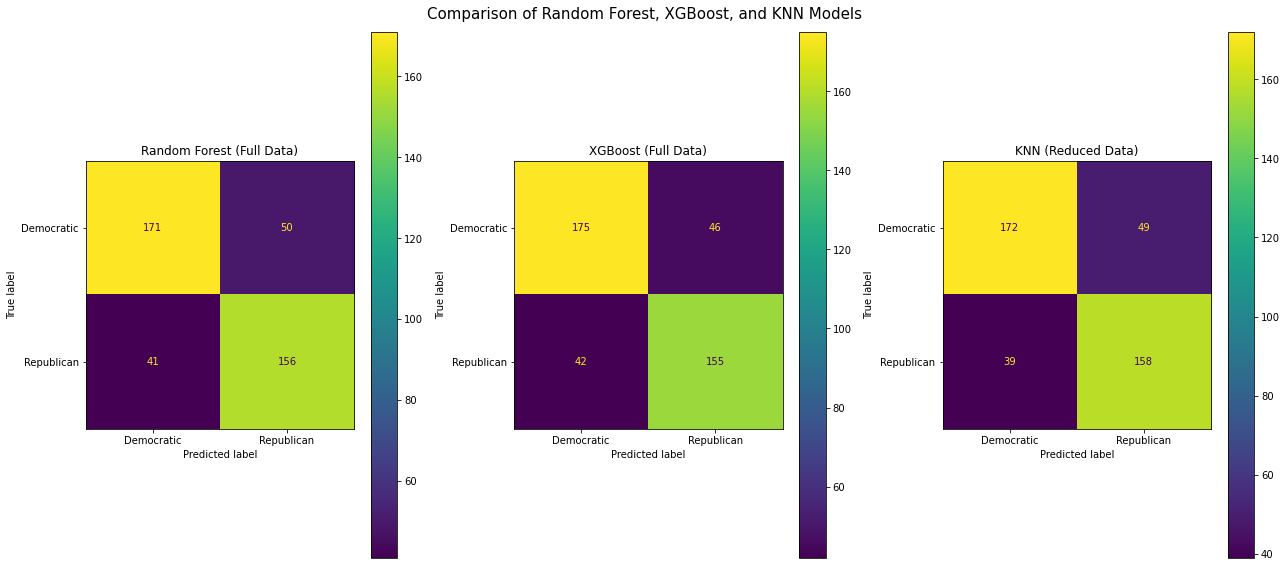

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

fig.suptitle('Comparison of Random Forest, XGBoost, and KNN Models', fontsize = 15)

axes[0].set_title("Random Forest (Full Data)")
axes[1].set_title("XGBoost (Full Data)")
axes[2].set_title("KNN (Reduced Data)")

plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[0],
                     display_labels=["Democratic", "Republican"])
plot_confusion_matrix(best_xg_model, X_test, y_test, ax=axes[1],
                     display_labels=["Democratic", "Republican"])
plot_confusion_matrix(best_knn_model, X_test_reduced, y_test, ax=axes[2],
                     display_labels=["Democratic", "Republican"])

fig.tight_layout();

There's a small reductions in overall accuracy relative to the XGBoost, but the KNN model compensates by doing the best at avoiding our worst outcome (surprise Republican wins, or "false negatives") and performs comparably in terms of precision and F1. At the moment, this is our best model per the metrics we prioritized at the beginning.

Can we see more improvement by reducing the dimensionality of the data even further by selecting the three variables that appeared in the top five most important for both the reduced random forest and reduced XGBoost?

In [98]:
X_train_reduced.columns

Index(['Average Amount Of Mortgage Payments', 'Average Age',
       'Average Annual Total Family Income',
       '% of Individuals Who Received Foodstamps', '% of Males',
       '% Another Language Is Spoken At Home', '% Non Spouse Present',
       '% Nonwhite', '% Non Natural Citizen', '% Some College Plus',
       '% Not Employed'],
      dtype='object')

In [99]:
# define X and y
X_knn = pres_df_reduced[['% Some College Plus', '% Non Natural Citizen', '% Not Employed']]
y_knn = pres_df_reduced['winner']
                              
# train-test split
X_train_knn, X_test_knn, y_train, y_test = train_test_split(X_knn, y_knn, test_size = .25, random_state = 270)

In [100]:
# instantiate parameters, pipeline, and gridsearch
knn_slim_params = {'model__n_neighbors': np.arange(1,12,2)}
knn_slim_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', KNeighborsClassifier())])
knn_slim_cv = GridSearchCV(estimator = knn_slim_pipe, scoring='recall', 
                      param_grid = knn_slim_params, cv = 5)

# fit gridsearch to slim training data
knn_slim_cv.fit(X_train_knn, y_train);

In [101]:
# examine best hyperparameters
knn_slim_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=11))])

In [102]:
# turn cross val results into dataframe for examination
pd.DataFrame(knn_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002430,0.000381,0.006821,0.000352,1,{'model__n_neighbors': 1},0.774194,0.822581,0.756098,0.741935,0.725806,0.764123,0.033297,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.002234,0.000030,0.007439,0.000020,3,{'model__n_neighbors': 3},0.806452,0.814516,0.772358,0.806452,0.758065,0.791568,0.022186,5,0.878788,0.907071,0.925403,0.907071,0.905051,0.904677,0.014909
2,0.002276,0.000072,0.007809,0.000190,5,{'model__n_neighbors': 5},0.790323,0.822581,0.788618,0.822581,0.733871,0.791595,0.032443,4,0.850505,0.878788,0.889113,0.850505,0.874747,0.868732,0.015602
3,0.002359,0.000210,0.008089,0.000200,7,{'model__n_neighbors': 7},0.758065,0.830645,0.772358,0.846774,0.830645,0.807697,0.035475,3,0.866667,0.858586,0.858871,0.848485,0.860606,0.858643,0.005856
4,0.002218,0.000028,0.008105,0.000080,9,{'model__n_neighbors': 9},0.774194,0.862903,0.772358,0.838710,0.830645,0.815762,0.036283,1,0.854545,0.830303,0.842742,0.828283,0.846465,0.840468,0.009911
5,0.002197,0.000004,0.008230,0.000056,11,{'model__n_neighbors': 11},0.814516,0.838710,0.764228,0.838710,0.822581,0.815749,0.027412,2,0.858586,0.836364,0.844758,0.838384,0.854545,0.846527,0.008746


In [103]:
# set hyperparameters for best model
best_knn_slim_model = knn_slim_cv.best_estimator_

# make predictions
y_pred_knn_slim = best_knn_slim_model.predict(X_test_knn)

In [104]:
# calculate performance metrics and add to evaluation dataframe
knn_prec_slim = precision_score(y_test, y_pred_knn_slim)
knn_rec_slim = recall_score(y_test, y_pred_knn_slim)
knn_acc_slim = accuracy_score(y_test, y_pred_knn_slim)
knn_f1_slim = f1_score(y_test, y_pred_knn_slim)

evaluation.loc[8] = ['K Nearest Neighbors - Slim',
                     '# Neighbors = 11',
                     knn_prec_slim, knn_rec_slim, knn_acc_slim, knn_f1_slim]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305
6,Tuned XGBoost - Reduced Data,"Estimators = 400, Learning Rate = .01",0.722488,0.766497,0.751196,0.743842
7,K Nearest Neighbors,# Neighbors = 9,0.763285,0.802030,0.789474,0.782178
8,K Nearest Neighbors - Slim,# Neighbors = 11,0.626126,0.705584,0.662679,0.663484


This model performed much worse along every performance metric, so we can discard it.

## Model 6: Stacking Model

For a final approach, we can stack our best models together to make an ensemble prediction. This is a similar approach to other ensembles like random forests or XGBoost, except while both of those approaches use numerous decision trees trained on the same data and combines their predictions, a stacked model is trained on multiple different **models** and combines the predictions of each model into one overall prediction. We can use the best of each of our models above to create a stacked model, which will hopefully further reduce the error.

In [105]:
# set best models
xgb_pipeline = best_xg_model_reduced
knn_pipeline = best_knn_model
rf_pipeline = rf_reduced_pipe
lr_pipeline = best_lr_reduced_model

# Define the stacking model with a logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_pipeline),
        ('knn', knn_pipeline),
        ('rf', rf_pipeline),
        ('lr', lr_pipeline),
    ],
    final_estimator=LogisticRegression()
)
# Fit the stacking model
stacking_model.fit(X_train_reduced, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=10,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.01,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=4, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=400, n_jobs=0,
                                              num_para...
                                                ('model',
                                

In [106]:
# generate predictions
y_pred_stacking = stacking_model.predict(X_test_reduced)

# calculate performance metrics and add to evaluation table
stacking_prec = precision_score(y_test, y_pred_stacking)
stacking_rec = recall_score(y_test, y_pred_stacking)
stacking_acc = accuracy_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)

evaluation.loc[9] = ['Stacking Model',
                     'Reduced Data, Final Estimator = KNN',
                     stacking_prec, stacking_rec, stacking_acc, stacking_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305
6,Tuned XGBoost - Reduced Data,"Estimators = 400, Learning Rate = .01",0.722488,0.766497,0.751196,0.743842
7,K Nearest Neighbors,# Neighbors = 9,0.763285,0.802030,0.789474,0.782178
8,K Nearest Neighbors - Slim,# Neighbors = 11,0.626126,0.705584,0.662679,0.663484
9,Stacking Model,"Reduced Data, Final Estimator = KNN",0.753695,0.776650,0.775120,0.765000


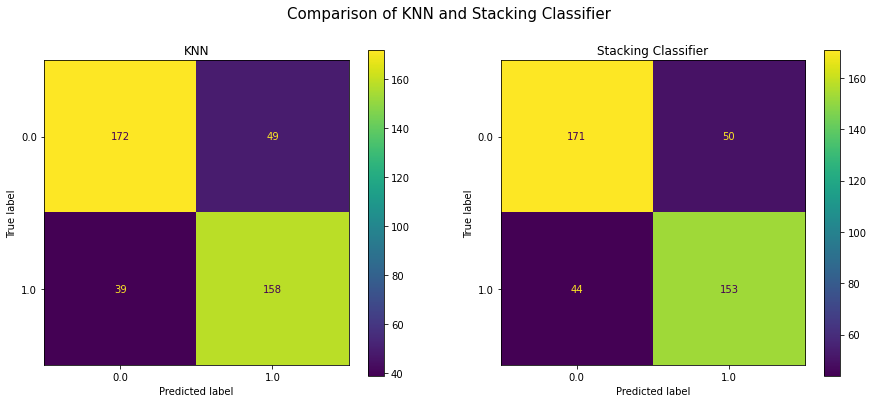

In [107]:
# Plot the confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Comparison of KNN and Stacking Classifier', fontsize = 15)

axes[0].set_title("KNN")
axes[1].set_title("Stacking Classifier")

plot_confusion_matrix(best_knn_model, X_test_reduced, y_test, ax=axes[0])
plot_confusion_matrix(stacking_model, X_test_reduced, y_test, ax=axes[1]);

Unfortunately, this model failed to improve on our individual models in terms of accuracy or recall.

## Final Model: K Nearest Neighbors

**After trying numerous approaches, we can say that based on its accuracy and recall scores, the KNN model using a 9 neighbors hyperparameter is the best for our purposes.** This makes sense intuitively - counties with similar demographic characteristics are likely to vote similarly at the presidential level!

In [108]:
# sort models by 
evaluation.sort_values('Recall', ascending = False)

,Model,Details,Accuracy,Recall,Precision,F1
7,K Nearest Neighbors,# Neighbors = 9,0.763285,0.802030,0.789474,0.782178
2,Tuned Random Forest,Max Depth = 4,0.757282,0.791878,0.782297,0.774194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
3,Tuned XGBoost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
0,Baseline Logistic Regression,-,0.747573,0.781726,0.772727,0.764268
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.742718,0.776650,0.767943,0.759305
9,Stacking Model,"Reduced Data, Final Estimator = KNN",0.753695,0.776650,0.775120,0.765000
6,Tuned XGBoost - Reduced Data,"Estimators = 400, Learning Rate = .01",0.722488,0.766497,0.751196,0.743842
4,Tuned Linear Regression - Reduced Data,C = 10,0.719212,0.741117,0.741627,0.730000
8,K Nearest Neighbors - Slim,# Neighbors = 11,0.626126,0.705584,0.662679,0.663484


## Applying the Model to the Full Dataset

Now that we have a final model, we can apply it to our full dataset to generate predictions for each county and identify where the model is making incorrect predictions.

In [109]:
# set final model
final_model = best_knn_model

In [110]:
# make predictions on training and test sets with same index as full dataset
full_train_preds = pd.DataFrame(final_model.predict(X_train_reduced), index = X_train_reduced.index, columns = ['predictions'])
full_test_preds = pd.DataFrame(final_model.predict(X_test_reduced), index = X_test_reduced.index, columns = ['predictions'])

# create an overall predictions dataframe
full_preds = pd.concat([full_train_preds, full_test_preds])
full_preds.shape

(1670, 1)

In [111]:
# merge predictions into full dataset
predictions_df = pd.merge(pres_df, full_preds[['predictions']], how='inner', left_index=True, right_index=True)

# rename columns for readability
predictions_df.rename(columns=descriptions_dict, inplace=True)
predictions_df.head()

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,state_po,county_name,democrat,green,liberitarian,other,republican,winner,predictions
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0,0.0


Now let's create a new column to identify correct predictions, surprise Democratic victories, and surprise Republican victories.

In [112]:
# set default value of column to "Correct"
predictions_df['wrong_prediction'] = 'Correct'

# identify and label counties where prediction was R and actual winner was D
predictions_df.loc[(predictions_df['winner'] == 0) & (predictions_df['predictions'] == 1), 'wrong_prediction'] = 'Dem surprise win'

# identify and label counties where prediction was D and actual winner was R
predictions_df.loc[(predictions_df['winner'] == 1) & (predictions_df['predictions'] == 0), 'wrong_prediction'] = 'Rep surprise win'

# get count for each category
predictions_df.groupby('wrong_prediction')['winner'].count()

wrong_prediction
Correct             1398
Dem surprise win     137
Rep surprise win     135
Name: winner, dtype: int64

It looks like when the model was wrong, it was roughly equally likely to be wrong in either direction. What are the states where it was most commonly wrong?

In [113]:
predictions_df.loc[predictions_df['wrong_prediction'] != 'Correct']['state_po'].value_counts().head(12)

TX    23
CA    18
NY    17
IL    16
IN    15
MI    15
PA    13
OH    13
FL    13
MN    13
WI    10
NJ     9
Name: state_po, dtype: int64

There are some key swing states on this list, including the "Blue Wall" states of Michigan, Pennsylvania, and Wisconsin that swung the 2016 and 2020 elections. This is a good reminder that even a good model can still miss enough predictions to possibly swing a national election!

Let's take a look at how each classification differs along a few key demographic categories - gender, race, education, and employment status.

In [114]:
# key columns
key_cols = ['% of Females',
             '% White',
             '% High School or Lower Education',
             '% Employed',
             'wrong_prediction']

# create subset df with only key columns
predictions_df_viz = predictions_df[key_cols]

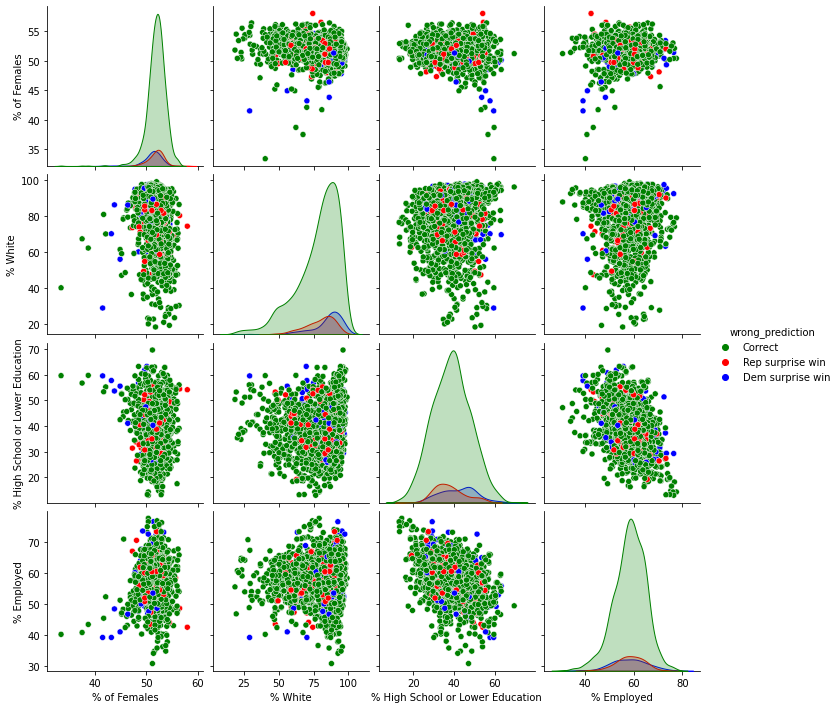

In [115]:
# Define a list of three different colors in RGB format
colors = ['g', 'r', 'b']

# Create a custom palette with the chosen colors
custom_palette = sns.color_palette(colors)

# create pairplot to visualize differences in key columns
sns.pairplot(data = predictions_df_viz, hue = 'wrong_prediction', palette = custom_palette);

There are two particularly interesting histograms here - the distribution of surprise victories in counties by race and education. Let's look at those more closely.

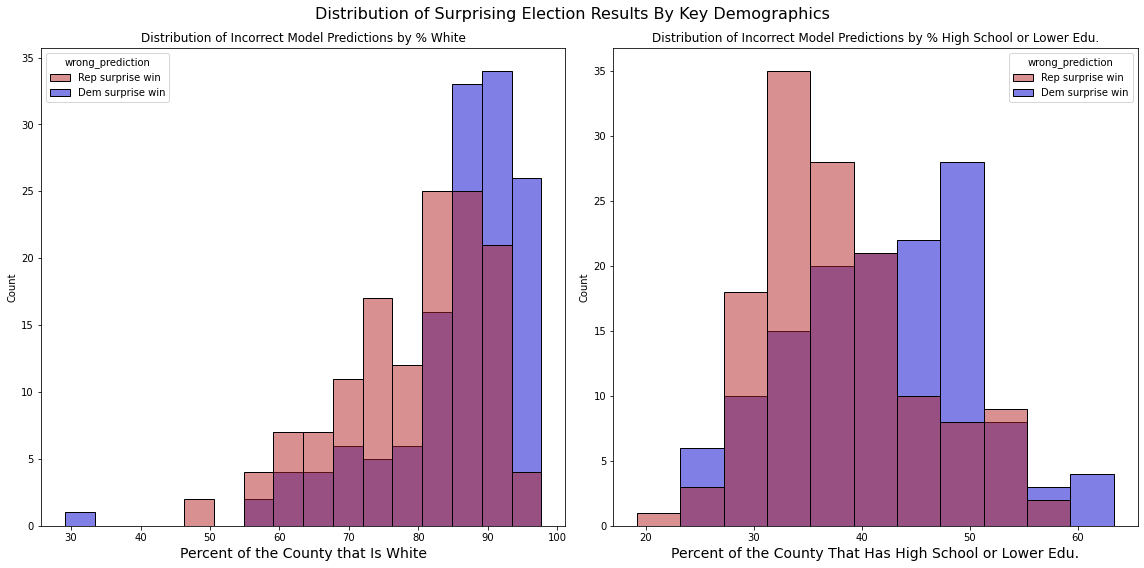

In [116]:
palette = ['firebrick', 'mediumblue']

fig, axes = plt.subplots(figsize = (16, 8), ncols = 2)

fig.suptitle('Distribution of Surprising Election Results By Key Demographics', fontsize = 16)


sns.histplot(data = predictions_df_viz.loc[predictions_df_viz['wrong_prediction'] != 'Correct'],
                                           x = '% White', hue = 'wrong_prediction', 
                                           palette = palette, ax = axes[0])
axes[0].set_title('Distribution of Incorrect Model Predictions by % White')
axes[0].set_xlabel('Percent of the County that Is White', fontsize = 14)

sns.histplot(data = predictions_df_viz.loc[predictions_df_viz['wrong_prediction'] != 'Correct'],
                                           x = '% High School or Lower Education', hue = 'wrong_prediction', 
                                           ax = axes[1], palette = palette)
axes[1].set_title('Distribution of Incorrect Model Predictions by % High School or Lower Edu.')
axes[1].set_xlabel('Percent of the County That Has High School or Lower Edu.', fontsize = 14)

fig.tight_layout();

These graphs show both the promise and peril of coming elections for the Democrats - they can still score surprising victories in areas where a high percentage of the population is White or has a higher than high school-level education, but they face downside risk in areas where a greater proportion of the population is nonwhite or has a higher level of education.

## Recommendations and Next Steps

Based on the analysis above, I can make the following recommendations:
1. Keep a particularly careful eye on counties where a large proportion is not in the labor force. This was the key predictor of Republican victories in one model, and an important feature in multiple models.
2. The party should use a distance-based model, such as a K Nearest Neighbors model, to generate its predictions because this model generated highest recall score, meaning it was the least likely to incorrectly predict a Democratic victory (false negative, in the context of this model). These incorrect predictions have the greatest downside to the party because they may result in losing an election unexpectedly.
3. Based on which predictions were incorrect, I recommend that the Democratic Party work to shore up its base to avoid further surprising electoral losses in counties with higher populations of color and higher educated communities.

With more time and data, I would like to make the following refinements to the model:
- Include more counties in the dataset from the last four elections to increase the amount of training data available.
- Include features related to the political composition of each county, such as voter registration statistics.
- Evaluate how county vote shares and demographics have changed over time to see if any relationships exist.